In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
import numba
from numba import jit
import random as rd
import matplotlib.mlab as mlab
from scipy import integrate as integrate
np.seterr(divide = 'ignore', invalid = 'ignore')  #"set error"  -  definimos como o programa lida com estes 
                                                    # erros "floating - point", no caso de estes poderem
                                                #gerar problemas numa das alíneas

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
@jit
def cond_iniciais (N,m,t0,r0,v0,escala_r,Tf):  #espécie de caixa negra
    '''Dados os parâmetros iniciais, define as condições iniciais do sistema, 
    adimensionaliza e redefine as órbitas para serem baricêntricas (centro de massa
    comum)'''
    
    #r0 e v0 do tipo [a,b,c,d,e,f]  -  - > [sol,terra]
    M=np.sum(m) #massa total do sistema
    Rx = 0  # posição do centro de massa x
    Ry = 0  # posição do centro de massa y
    Rz = 0  # posição do centro de massa z
    Vx = 0  # velocidade do centro de massa x
    Vy = 0  # velocidade do centro de massa y
    Vz = 0  # velocidade do centro de massa z
    for i in range(N):
        #adicionamos todas as posições e velocidades, componente a componente, 
        #para depois calcularmos centro de massa e passar para órbita baricêntrica,
        #de acordo com as eqs.(4.5) e (4.6)
        Rx += m[i] * r0[i*3]  #*3 para andar de 3 em 3; só queremos componente x
        Ry += m[i] * r0[i*3+1] #começa na segunda e anda 3 a 3, para ser só comp.y
        Rz += m[i] * r0[i*3+2]
        
        Vx += m[i] * v0[i*3]
        Vy += m[i] * v0[i*3+1]
        Vz += m[i] * v0[i*3+2]
        
    #print(Rx)
    #print(Ry)
    #print(Rz)
    #print(Vx)
    #print(Vy)
    #print(Vz)
    #print(M)
    
    Rcm=np.array([Rx/M,Ry/M,Rz/M])  #será um vetor com uma coluna só; pos.centro massa
    Vcm=np.array([Vx/M,Vy/M,Vz/M]) #velocidade centro de massa, comp. a componente
    
    
    #É ainda preciso redimensionalizar e retirar CM (baricêntrico depois)
    
    R = escala_r  #raio que definimos como parâmetro inicial; escala típica do sistema
    
    
    vr = np.sqrt(G * M/(2 * R))  #eqs. 4.20,4.24; velocidade de referência
    
    #ar=G*M/R**2           #Tirar de comentário se necessário, no fim; eqs. (4.23/4.24)
    tr = np.sqrt(8 * R**3/(G * M))  #eqs. 4.24 e 4.30
    
    u = t0 / tr  # tempo adimensionalizado, usando tempo referência tr; eq. (4.22)
    mass = m / M #massa adimensionalizada; M é m. ref., eqs. 4.22 e 4.30; qi na sebenta
#    print('massa',mass)
    
#    dt = (Tf  -  t0)/passos
#    du = dt / tr
    
    T = Tf / tr  #Tempo adimensionalizado em função de tempo de referência tr; (4.22)
    
    for n in range(N):        #r0 e v0 são pos. e vel. corpos, dadas como par.iniciais
        #agora, vamos componente a componente retirar as grandezas do centro de massa,
        #para ficarmos com pos. e vel. de cada corpo nas coord. baricêntricas
        r0[n * 3]  -= Rcm[0]
        r0[n * 3 + 1]  -= Rcm[1]
        r0[n * 3 + 2]  -= Rcm[2]
        
        
        v0[n * 3]  -= Vcm[0]
        v0[n * 3 + 1]  -= Vcm[1]
        v0[n * 3 + 2]  -= Vcm[2]
    
    
    x = np.zeros(len(r0))
    y = np.zeros(len(v0))
    
    for s in range(len(r0)):
        #dividir parâmetros iniciais, já baricêntricos, por valores ref., 
        #para adimensionalziar
        x[s] = r0[s] / R
        y[s] = v0[s] / vr

    return mass,u,x,y,T 
    #dá return às quantidades já adimensionalizadas e baricêntricas



In [27]:
def trajetoria3D_exc(N,m,t,r,v,escala,Temp,T_orb):
    'Esta função calcula também a excentricidade'
    'Nota: Esta função é em 3D e suporta gráficos de 4 corpos, que são os que vou'
    'usar num dos casos em estudo'
    'Evolui as posições e velocidades das partículas do sistema'
    'argumentos: número de corpos, massas,tempo, posição e velocidades iniciais,'
    'escala espacial do sistema, Tempo final de simulação, T são períodos orbitais'
    'dos planetas  (vai ter len N-1 no caso de o sistema ter uma estrela)'
    mass,t0,x,y,Tf  =  cond_iniciais(N,m,t,r,v,escala,Temp)
    #Notar que já vêm adimensionalizadas e no referencial do centro de massa
#    du  =  d * 1

    
    xx  =  np.zeros(N)
    yy  =  np.zeros(N)
    zz  =  np.zeros(N)

    vx  =  np.zeros(N)
    vy  =  np.zeros(N)
    vz  =  np.zeros(N)
    
    pa  =  1E-6   #delta u da sebenta; distância temporal entre passos
    
    for s in range(N):
        print('\n s  =  ', (s/N  *  100), ' %')
        xx[s]  =  x[3 * s]
        yy[s]  =  x[3 * s+1]
        zz[s]  =  x[3 * s+2]
    
        vx[s]  =  y[3 * s]
        vy[s]  =  y[3 * s+1]
        vz[s]  =  y[3 * s+2]
        
    X  =  np.array([np.zeros(len(xx)),xx])
    Y  =  np.array([np.zeros(len(yy)),yy])
    Z  =  np.array([np.zeros(len(zz)),zz])
    
    VX  =  np.array([np.zeros(len(vx)),vx])
    VY  =  np.array([np.zeros(len(vy)),vy])
    VZ  =  np.array([np.zeros(len(vz)),vz])
    
    Energia  =  []
    tempo  =  []
    
    # O vetor b tem 3 componentes, que mudam a cada ciclo
    aa  =  0
    print_list = [100,1000,5000,10000,25000,50000,75000,100000,125000,150000,200000,350000,500000,1000000,1500000,2000000,3000000]
    #t0_list = np.arange(0,Tf,100)
    while t0 < Tf:
        #print('passo  =  ' , aa, '\n t0,Tf: ', t0,Tf)
        if aa in print_list:
            print(aa , 'passos. T0,Tf = ', t0,Tf )
        aa += 1
        passos  =  np.zeros(N)
        
        Ec  =  0
        Ep  =  0
        for c in range(N):
            #print('\n c  =  ', c / N  *  100, ' %')
            Ec +=  mass[c] * (vx[c] ** 2 + vy[c] ** 2 + vz[c] ** 2)
            
            for p in range(N):
                #print('\n p  =  ', p / N  *  100, ' %')
                if p == c:
                    continue
                if p!= c:
                    Ep +=  mass[c] * mass[p] / (np.sqrt((xx[c]  -  xx[p]) ** 2 + (yy[c]  -  yy[p]) ** 2 + (zz[c]  -  zz[p]) ** 2))
                
        Energia.append(Ec  - G * 0.5 * Ep)
        
        ### Acelerações
        
        bx  =  np.zeros(N)
        by  =  np.zeros(N)
        bz  =  np.zeros(N)
        
        for i in range(N):
            #print('\n i  =  ', i / N  *  100, ' %')
            for d in range(N):
                #print('\n d  =  ', d / N  *  100, ' %; d é sub - ciclo')
                if d!= i:
                    norma  =  np.sqrt((xx[i]  -  xx[d]) ** 2 + (yy[i]  -  yy[d]) ** 2 + (zz[i]  -  zz[d]) ** 2)
                    #print('args',mass[d],xx[i],xx[d])
                    bx[i] +=  mass[d] * (xx[i] - xx[d])/norma ** 3
                    by[i] +=  mass[d] * (yy[i] - yy[d])/norma ** 3
                    bz[i] +=  mass[d] * (zz[i] - zz[d])/norma ** 3
            
                    #print(xx[i],xx[d])
                    
                if d == i:
                    continue
        #print('bx',bx)
            #print('by',by)
#        print('bx',bx[1])
#        print('by',by)
#         
        'Agora determinar delta u da eq. 4.42'
        for e in range(N):
            #print('\n e  =  ', e/N  *  100, ' %')
#            print('1', np.sqrt(xx[e] ** 2+yy[e] ** 2+zz[e] ** 2)/np.sqrt(vx[e] ** 2+vy[e] ** 2+vz[e] ** 2))
#            print('2', np.sqrt(vx[e] ** 2+vy[e] ** 2+vz[e] ** 2)/np.sqrt(bx[e] ** 2+by[e] ** 2+bz[e] ** 2))
            passos[e]  =  0.5  *  min(np.sqrt(xx[e] ** 2+yy[e] ** 2 + zz[e] ** 2)/np.sqrt(vx[e] ** 2+vy[e] ** 2+vz[e] ** 2) , np.sqrt(vx[e] ** 2+vy[e] ** 2+vz[e] ** 2)/np.sqrt(bx[e] ** 2+by[e] ** 2+bz[e] ** 2))
#            print('p',passos)

            #DAS EQUAÇÕES 4.41:
            xx[e]  =  xx[e] + 2 * vx[e] * pa  - 4 * bx[e] * pa ** 2
            yy[e]  =  yy[e] + 2 * vy[e] * pa  - 4 * by[e] * pa ** 2
            zz[e]  =  zz[e] + 2 * vz[e] * pa  - 4 * bz[e] * pa ** 2
            
            #print('posicoes',xx,yy,zz)
        
            vx[e]  =  vx[e]  -  4 * bx[e] * pa
            vy[e]  =  vy[e]  -  4 * by[e] * pa
            vz[e]  =  vz[e]  -  4 * bz[e] * pa
            
            #print('vT', vx[1],vy[1])
        
#        print(xx)
#        print(yy)
        #print('du',du)
#        print(vy)
        X  =  np.concatenate((X,[np.array(xx)]),axis = 0)
        Y  =  np.concatenate((Y,[np.array(yy)]),axis = 0)
        Z  =  np.concatenate((Z,[np.array(zz)]),axis = 0)
        #print('shape: \n' , np.shape(X), np.shape(Y), np.shape(Z))

        VX  =  np.concatenate((VX,[np.array(vx)]),axis = 0)
        VY  =  np.concatenate((VY,[np.array(vy)]),axis = 0)
        VZ  =  np.concatenate((VZ,[np.array(vz)]),axis = 0)

        pa  =  0.5 * np.min(passos) * 8E-4

        t0  =  t0 + pa
        tempo.append(t0)
        #print('aaa \n' , N,len(X[1:,0]))
        sh = np.shape(X)
        distancia = np.zeros(sh)
#         print('distancia: \n ', distancia)
#         print('X[1:,0] : \n',X[1:,0])
#         print('X : \n', X)
        
#         for p in range(N):
#             print('p = ', p)
#             for k in range(len(X[1:,0])-1):
#                 print('k = ', k)
#                 #print('AGORA \n ', (X[p,k]),(Y[p,k]),(Z[p,k]))
#                 distancia[p,k] = np.sqrt((X[p,k])**2 + (Y[p,k])**2 + (Z[p,k])**2)
    
    #print(du)
   # print(tempo)
    'Órbitas'
#     for q in range(N):
#         print('\n Órbitas')
#         #print('\n q  =  ', q/N  *  100, ' %')
# #         plt.plot(X[1:,q],Y[1:,q])
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    #ax = fig.add_subplot(111, projection='3d')
    ax.plot(X[1:,0],Y[1:,0],Z[1:,0], label = 'Corpo' +str(1))
    ax.plot(X[1:,1],Y[1:,1],Z[1:,1], label = 'Corpo' +str(2))
    ax.plot(X[1:,2],Y[1:,2],Z[1:,2], label = 'Corpo' +str(3))
    if N == 4:
        ax.plot(X[1:,3],Y[1:,3],Z[1:,3], label = 'Corpo' +str(4))

#     plt.ylabel('direção y', fontsize = 14)
#     plt.xlabel('direção x', fontsize = 14)

    plt.savefig('Orbitas3D.pdf', orientation = 'landscape', format = 'pdf')
    ax.legend()
    plt.show()

    'Posições em função do tempo'
#Mudar em função dos corpos usados
    plt.plot(tempo, X[2:,0], label = 'Corpo A', color = 'orange')
    plt.plot(tempo, X[2:,1], label = 'Corpo B', color = 'b')
    plt.plot(tempo, X[2:,2], label = 'Corpo C', color = 'green')
    if N == 4:
        plt.plot(tempo, X[2:,3], label = 'Corpo D', color = 'fuchsia')
    plt.ylabel('Eixo dos X', fontsize = 14)
    plt.xlabel('$t/t_r$', fontsize = 14)
    plt.legend()
    plt.savefig('X tempo3_.pdf', orientation = 'landscape', format = 'pdf')
    plt.show()

    plt.plot(tempo, Y[2:,0], label = 'Corpo A', color = 'orchid')
    plt.plot(tempo, Y[2:,1], label = 'Corpo B', color = 'gold')
    plt.plot(tempo, Y[2:,2], label = 'Corpo C', color = 'steelblue')
    if N == 4:
        plt.plot(tempo, Y[2:,3], label = 'Corpo D', color = 'fuchsia')
    plt.ylabel('Eixo dos Y', fontsize = 14)
    plt.xlabel('$t/t_r$', fontsize = 14)
    plt.legend()
    plt.savefig('Y tempo3_.pdf', orientation = 'landscape', format = 'pdf')
    plt.show()
    
    plt.plot(tempo, Z[2:,0], label = 'Corpo A', color = 'orchid')
    plt.plot(tempo, Z[2:,1], label = 'Corpo B', color = 'gold')
    plt.plot(tempo, Z[2:,2], label = 'Corpo C', color = 'steelblue')
    if N == 4:
        plt.plot(tempo, Z[2:,3], label = 'Corpo D', color = 'fuchsia')
    plt.ylabel('Eixo dos Z', fontsize = 14)
    plt.xlabel('$t/t_r$', fontsize = 14)
    plt.legend()
    plt.savefig('Z tempo3_.pdf', orientation = 'landscape', format = 'pdf')
    plt.show()
    
    'Energia em função do tempo'
    plt.plot(tempo,(Energia/Energia[0]))
    plt.xlabel('Tempo/tr', fontsize = 14)
    plt.ylabel('$Energia/E_{inicial}$', fontsize = 14)
    plt.savefig('Energia.pdf', orientation = 'landscape', format = 'pdf')
    plt.show()
    
    distancia_min = np.zeros(N-1)  #para depois calcular excentricidade
    distancia_max = np.zeros(N-1)
    for i in range(len(distancia_min)):
        distancia_min[i] =np.min(np.sqrt((X[1:,i+1])**2+(Y[1:,i+1])**2+(Z[1:,i+1])**2))
        #i+1 para não contar a estrela, que é o primeiro corpo
        distancia_max[i] =np.max(np.sqrt((X[1:,i+1])**2+(Y[1:,i+1])**2+(Z[1:,i+1])**2))
    dist_min_cgs, dist_max_cgs = distancia_min*escala, distancia_max*escala
    #OK, assim já dá a distância em CGS
    print(dist_min_cgs, dist_max_cgs)
    #Agora obter a, o semi-eixo maior
    a = np.zeros(N-1) #a estrela não precisa
    b = np.zeros(N-1)
    mu = np.zeros(N-1)
    for i in range(len(a)):
        a[i] = (dist_max_cgs[i]+dist_min_cgs[i])/2
        b[i] = np.sqrt(dist_max_cgs[i]*dist_min_cgs[i])
#         mu[i] = G * m[i+1]
#         a[i] = ((T_orb[i]*mu[i])/(2*np.pi))**(2/3)
        #aqui não é preciso i+1 no T, porque só são introduzidos os períodos dos planetas
    exc = np.zeros(N-1)
    #(rp/a)-1
    for i in range(len(exc)):
        #print(i)
        #print('\n ' , dist_min_cgs[i], a[i])
        #exc[i] = (dist_min_cgs[i]/a[i])
        exc[i] = np.sqrt(1-((b[i]**2)/a[i]**2))
    return exc

In [4]:
m_Sol = 1.988475e33 #cgs
m_Terra = 5.972365e27 #cgs
m_Marte = 6.4171e26 #cgs
d_TerraSol = 1.496e13 #cgs
d_MarteSol = 2.279e13 #cgs
Mj = 1.8986E30
ua = 1.4959787061E13  #tudo em cgs
G=6.67408E-8   #Constante gravitacional
M_Jupiter = Mj


In [20]:
#Sistema HD 37124, versão polaco, usando dados 2002
#Incertezas - variar talvez?
m_HD = 0.91*m_Sol
#velocidades dadas pela eq. 4.53
'Planeta b'
mb = 0.86 * M_Jupiter
ab = 0.54*ua
T_b = 153 * 24 * 3600          #período em segundos
vb = np.sqrt(G*(mb+m_HD)/(ab))
'Planeta c'
mc = 1.01 * M_Jupiter
ac = 2.95 * ua
T_c = 1942 * 24 * 3600
vc = np.sqrt(G*(mc+m_HD)/(ac))

#lista_unitários = [[],[],[],[],[],[]]

@jit
def random_normalizado(N,escala, incerteza):
    'dá return a N vetores normalizados gerados aleatoriamente'
    cont = 0
    A = np.zeros(2*N)   #duas vezes já chega para o length ser basicamente sempre 100
    B = np.zeros(2*N)
    C = np.zeros(2*N)
    unit1 = []
    unit2 = []
    unit3 = []
    for i in range(2*N):
        A[i] = rd.random()
        B[i] = rd.random()
        C[i] = rd.random()
#     while len(unit1) < N:  #assim faz até termos N vetores unitários - útil para depois
    for k in range(len(A)):
#         if len(unit1) == 50:
#                 print('Checkpoint 50')  #Assim só dá print 1 vez
        #print(k)
        for j in range(len(B)):
            if len(unit1) == N:
                        break
#             if len(unit1) == 25:
#                 print('Checkpoint 25')
#             if len(unit1) == 50:
#                 print('Checkpoint 50')
                
#             if len(unit1) == 75:
#                 print('Checkpoint 75')
            #print(j)
            for z in range(len(C)):
                #print(z)
                if (A[k] + B[j] + C[z]) - 1 <= 1e-4: 
                #if np.sqrt((A[k])**2 + (B[j])**2 + (C[z])**2) - 1 <= 1e-6:
                    if A[k] in unit1:   #para não dar repetidos
                        break
                    else:
                  #Nota: Multiplicar por rd.choice(-1,1) para sinais serem aleatórios
                        unit1.append((escala-incerteza+2*incerteza*rd.random())*A[k])
                        unit2.append((escala-incerteza+2*incerteza*rd.random())*B[j])
                        unit3.append((escala-incerteza+2*incerteza*rd.random())*C[z])
                        cont+=1
                    #break
                    #print('Um foi adicionado')

    return np.array(unit1),np.array(unit2),np.array(unit3)
                    

In [10]:
len(random_normalizado(100,1,0)[1])
#random_normalizado(100)[0][20]

Checkpoint 50


100


 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.009684418834313183 0.2842112892515991
1000 passos. T0,Tf =  0.09414023108493703 0.2842112892515991


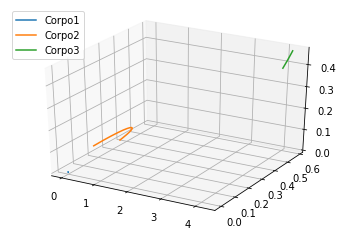

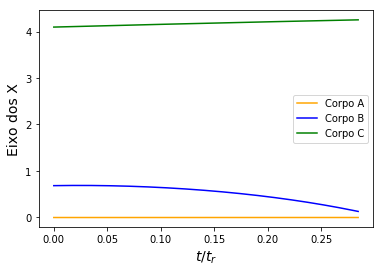

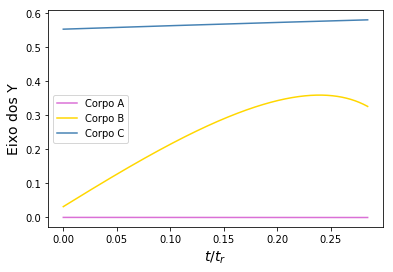

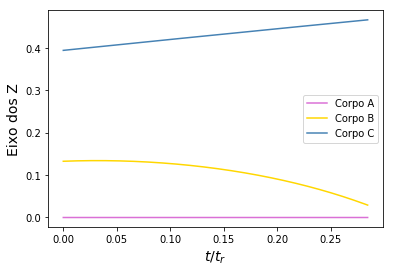

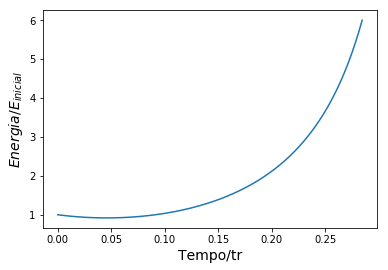

[2.82857651e+12 3.35400896e+13] [5.69508791e+12 3.48704491e+13]

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.010513869965377589 0.2842112892515991
1000 passos. T0,Tf =  0.10222289981427488 0.2842112892515991


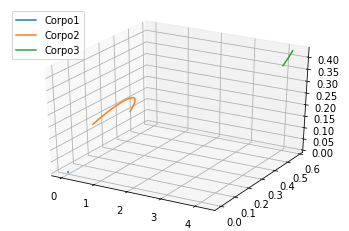

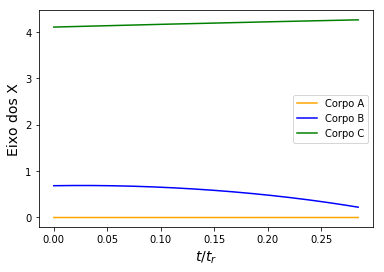

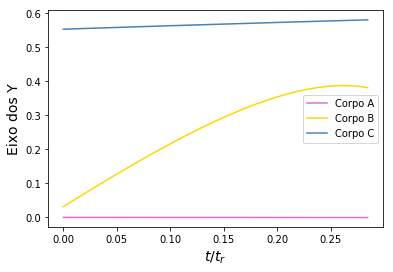

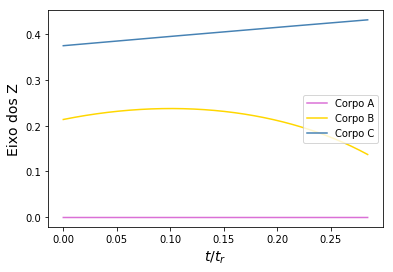

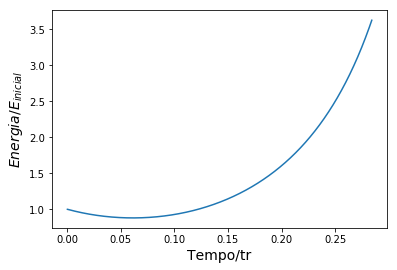

[3.70819925e+12 3.35839317e+13] [5.91012740e+12 3.48995211e+13]

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.00954945021796444 0.2842112892515991
1000 passos. T0,Tf =  0.09271203899623623 0.2842112892515991


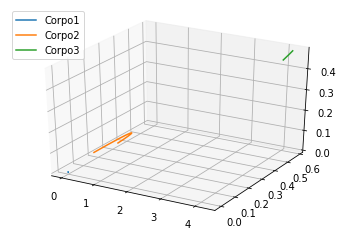

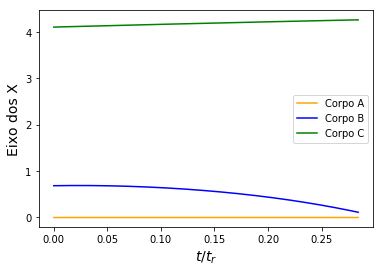

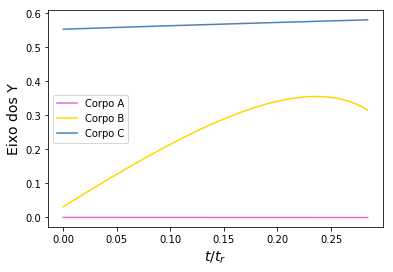

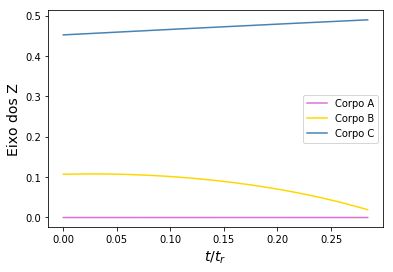

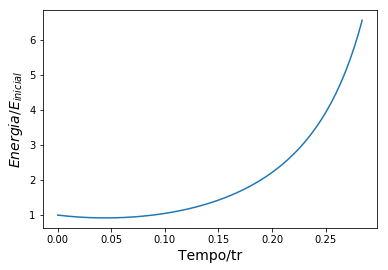

[2.69196887e+12 3.36465988e+13] [5.65401603e+12 3.49507628e+13]

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.00998267126171957 0.2842112892515991
1000 passos. T0,Tf =  0.09721315044796448 0.2842112892515991


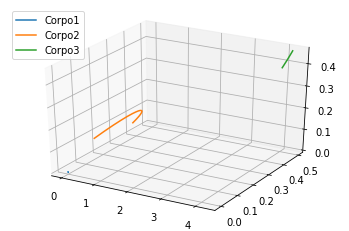

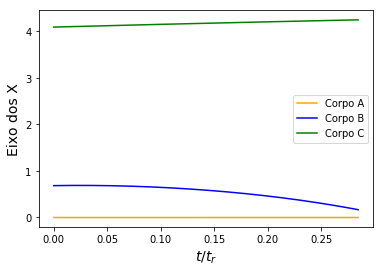

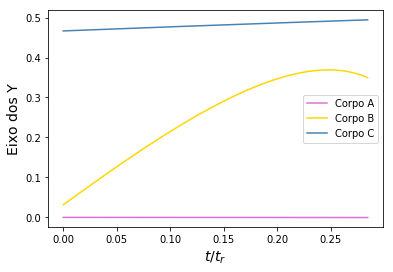

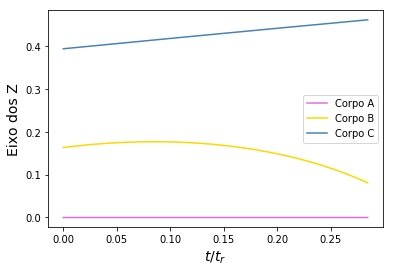

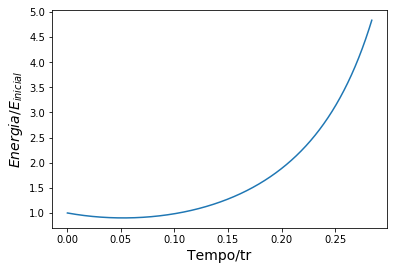

[3.18689481e+12 3.34393451e+13] [5.77097827e+12 3.47638370e+13]

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.009440563150893007 0.2842112892515991
1000 passos. T0,Tf =  0.09189894709918434 0.2842112892515991


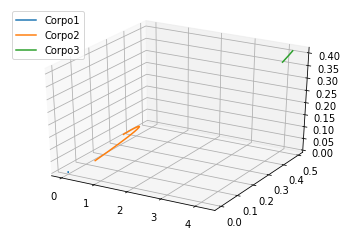

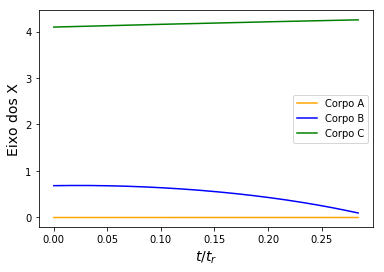

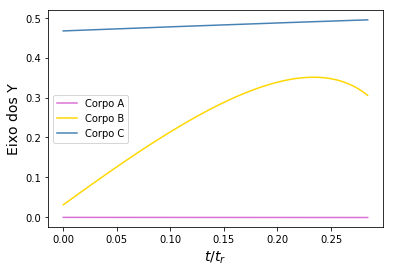

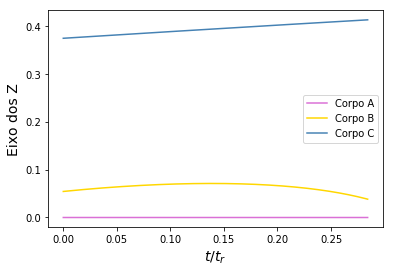

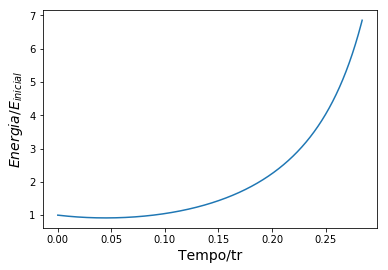

[2.59730530e+12 3.34598024e+13] [5.60853688e+12 3.47587815e+13]

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.010729169408345741 0.2842112892515991
1000 passos. T0,Tf =  0.10434049558649383 0.2842112892515991


KeyboardInterrupt: 

In [14]:
N = 10
# vb = 27.82 + 1.56*rd.random()  #duas vezes a incerteza, valor é 28.50 +- 0.78
# vc = 14.2 + 2.4*rd.random()  #15.4 +-1.2
ab = 0.54*ua
vb = np.sqrt(G*(mb+m_HD)/(ab))
ac = 2.95 * ua
vc = np.sqrt(G*(mc+m_HD)/(ac))
# vb = 27.82
# vc = 15.4
unit1,unit2,unit3 = random_normalizado(N,vb,0.78)
unit4,unit5,unit6 = random_normalizado(N,vc,1.2)
#Agora para as posições iniciais, de modo a que sejam aleatórias e não sejam
# "direitinhas" no afélio
pos1,pos2,pos3 = random_normalizado(N,ab,0.00020*ua)
pos4,pos5,pos6 = random_normalizado(N,ac,0.0065*ua) 
#print(len(unit1),unit4)
exc_list = np.zeros(N)
exc_list2 = np.zeros(N)
for i in range(N):
    A = trajetoria3D_exc(3,np.array([m_HD,mb,mc]),0,
                    np.array([0,0,0,pos1[i],pos2[i],pos3[i],pos4[i],pos5[i],pos6[i]]),
            np.array([0,0,0,unit1[i],unit2[i],unit3[i],unit4[i],unit5[i],unit6[i]]),
                                   ab,T_c/100,T_c)
    exc_list[i] = A[0]
    exc_list2[i] = A[1]
#     exc_list[i], exc_list2[i] = trajetoria3D_exc(3,np.array([m_HD,mb,mc]),0,
#                     np.array([0,0,0,ab,0,0,ac,0,0]),
#             np.array([0,0,0,unit1[i],unit2[i],unit3[i],unit4[i],unit5[i],unit6[i]]),
#                                    ab,T_c/100,T_c)[0],
#     trajetoria3D_exc(3,np.array([m_HD,mb,mc]),0,
#                     np.array([0,0,0,ab,0,0,ac,0,0]),
#             np.array([0,0,0,unit1[i],unit2[i],unit3[i],unit4[i],unit5[i],unit6[i]]),
#                                    ab,T_c/100,T_c)[1]
print(exc_list)
print(exc_list2)

Checkpoint 75
0 de 50

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  3.688892298931547e-08 4.478303527857329
1000 passos. T0,Tf =  5.363568020754658e-07 4.478303527857329
5000 passos. T0,Tf =  2.3185598364523605e-05 4.478303527857329
10000 passos. T0,Tf =  0.0012543652697825894 4.478303527857329
50000 passos. T0,Tf =  0.13885118587845116 4.478303527857329
100000 passos. T0,Tf =  0.13892473514468343 4.478303527857329
150000 passos. T0,Tf =  0.13895496445296987 4.478303527857329


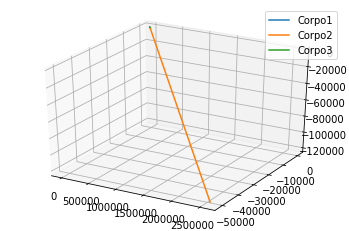

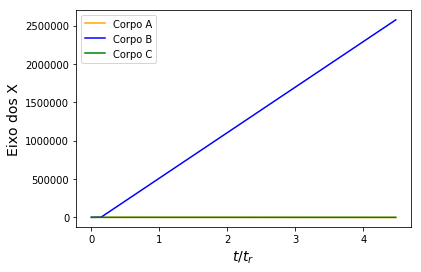

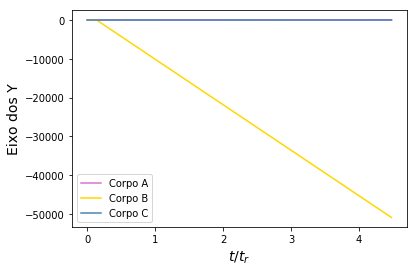

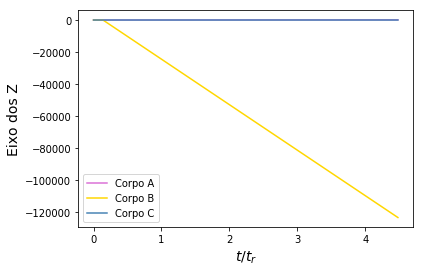

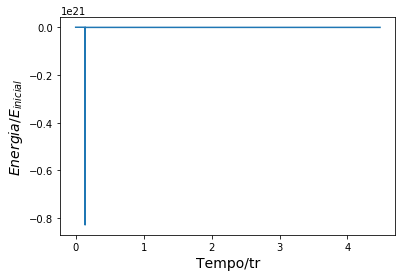

[2.17253770e+05 4.26615915e+13] [2.08268330e+19 4.40810587e+13]
1 de 50

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  3.333744142607955e-08 4.478303527857329
1000 passos. T0,Tf =  4.877354550306749e-07 4.478303527857329
5000 passos. T0,Tf =  2.10794775199519e-05 4.478303527857329
10000 passos. T0,Tf =  0.0011540430098249729 4.478303527857329
50000 passos. T0,Tf =  0.14744309863531346 4.478303527857329
100000 passos. T0,Tf =  0.14751663157089398 4.478303527857329
150000 passos. T0,Tf =  0.1475176676455027 4.478303527857329


In [ ]:
N = 50
aaa = np.linspace(ab/2,1.5*ab,N)  #isto seria para estudar influência da distância
#à estrela
vb = 27.82
vc = 15.4
unit1,unit2,unit3 = random_normalizado(N,vb,0.78)
#print(unit1,unit2,unit3)
unit4,unit5,unit6 = random_normalizado(N,vc,1.2)
#print(len(unit1),unit4)
exc_list = np.zeros(N)
exc_list2 = np.zeros(N)
for i in range(N):
    print(i , 'de', N)
    A = trajetoria3D_exc(3,np.array([m_HD,mb,mc]),0,
                    np.array([0,0,0,aaa[i],0,0,ac,0,0]),
            np.array([0,0,0,unit1[i],unit2[i],unit3[i],unit4[i],unit5[i],unit6[i]]),
                                   ab,2*T_b,T_c)
    exc_list[i],exc_list2[i] = A[0],A[1]
    
    
plt.plot(aaa,exc_list, ".")
plt.show()
plt.plot(aaa,exc_list2,".")
plt.show()
# plt.hist(aaa,exc_list)
# plt.show()

1 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008543485371946172 2.2391517639286644
1000 passos. T0,Tf =  0.07234870536952154 2.2391517639286644
5000 passos. T0,Tf =  0.21225394689186913 2.2391517639286644
10000 passos. T0,Tf =  0.3901172268258823 2.2391517639286644
25000 passos. T0,Tf =  0.41011738825005656 2.2391517639286644
50000 passos. T0,Tf =  0.9602613262650935 2.2391517639286644
75000 passos. T0,Tf =  1.516965763345055 2.2391517639286644
100000 passos. T0,Tf =  2.031097373548163 2.2391517639286644


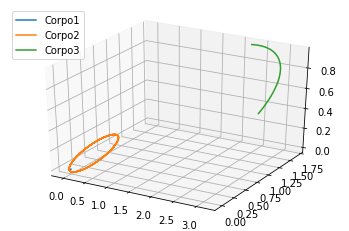

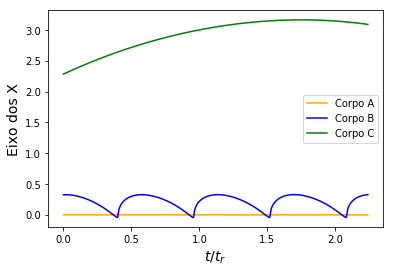

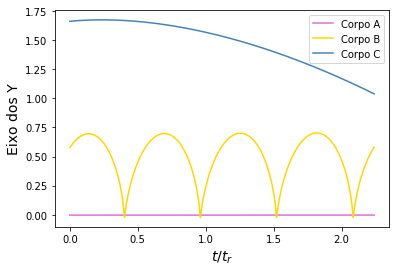

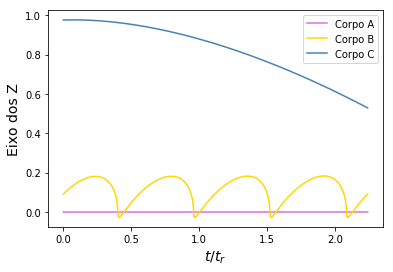

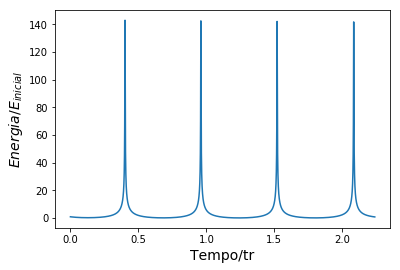

[1.96867898e+11 2.41279610e+13] [6.26744659e+12 2.85377879e+13]
2 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008007922230039594 2.2391517639286644
1000 passos. T0,Tf =  0.06704930388691867 2.2391517639286644
5000 passos. T0,Tf =  0.20404518791450688 2.2391517639286644
10000 passos. T0,Tf =  0.3703281065897364 2.2391517639286644
25000 passos. T0,Tf =  0.38742405480696157 2.2391517639286644
50000 passos. T0,Tf =  0.9176503687059213 2.2391517639286644
75000 passos. T0,Tf =  1.453125722168367 2.2391517639286644
100000 passos. T0,Tf =  1.9247048654834757 2.2391517639286644
125000 passos. T0,Tf =  2.193395445216617 2.2391517639286644


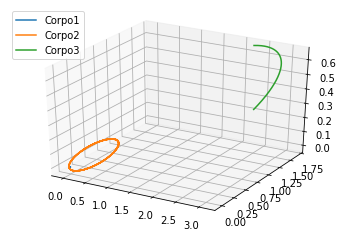

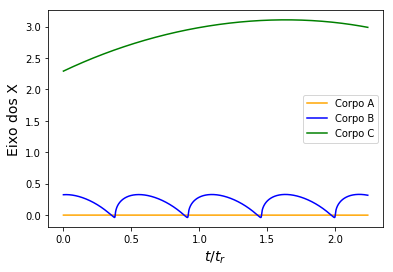

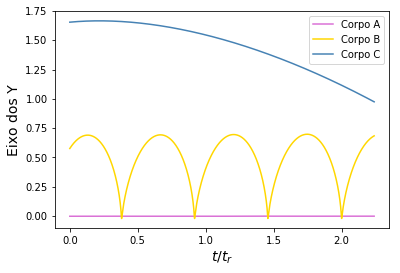

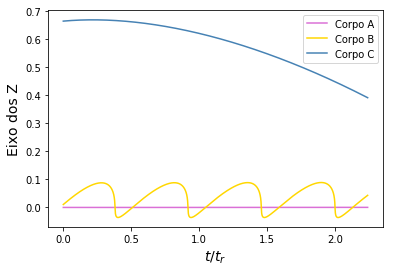

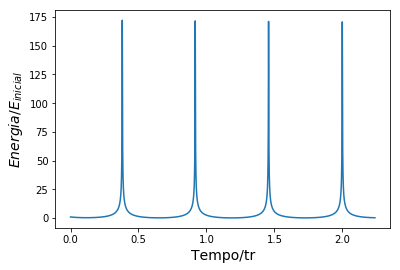

[1.76578497e+11 2.34552143e+13] [6.12482947e+12 2.78370584e+13]
3 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.00815427733539761 2.2391517639286644
1000 passos. T0,Tf =  0.06847570005864387 2.2391517639286644
5000 passos. T0,Tf =  0.20400985282893608 2.2391517639286644
10000 passos. T0,Tf =  0.37541901138608513 2.2391517639286644
25000 passos. T0,Tf =  0.3932282498505947 2.2391517639286644
50000 passos. T0,Tf =  0.9288575114997415 2.2391517639286644
75000 passos. T0,Tf =  1.4703414829356913 2.2391517639286644
100000 passos. T0,Tf =  1.9719652333070958 2.2391517639286644


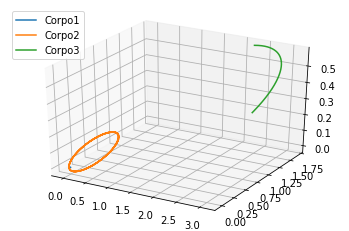

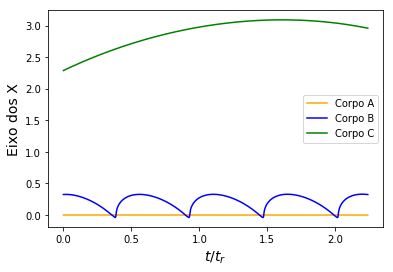

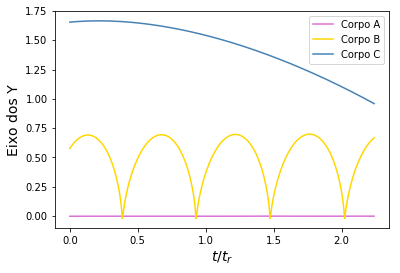

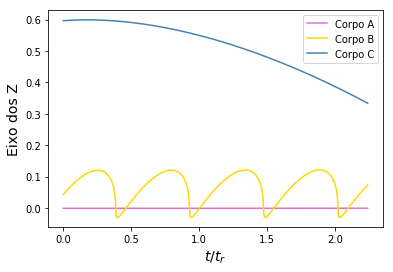

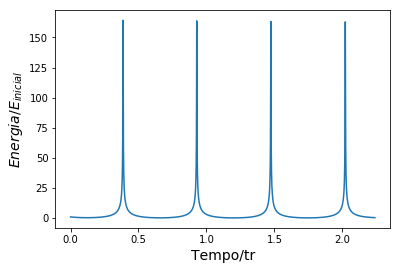

[1.80414162e+11 2.33178602e+13] [6.16269224e+12 2.76464014e+13]
4 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008002492135234497 2.2391517639286644
1000 passos. T0,Tf =  0.06645209854775516 2.2391517639286644
5000 passos. T0,Tf =  0.18040090788608845 2.2391517639286644
10000 passos. T0,Tf =  0.3687732738965007 2.2391517639286644
25000 passos. T0,Tf =  0.3862609153033177 2.2391517639286644
50000 passos. T0,Tf =  0.9211043831484307 2.2391517639286644
75000 passos. T0,Tf =  1.3812796552296343 2.2391517639286644
100000 passos. T0,Tf =  1.6210378056625256 2.2391517639286644
125000 passos. T0,Tf =  2.0151192916038627 2.2391517639286644


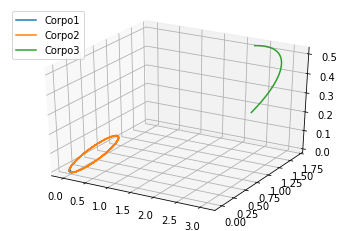

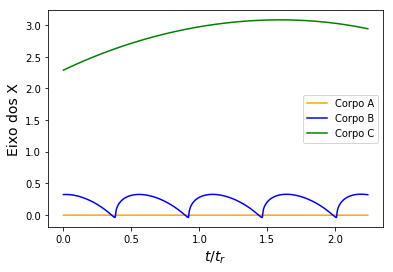

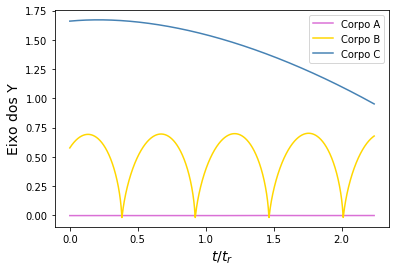

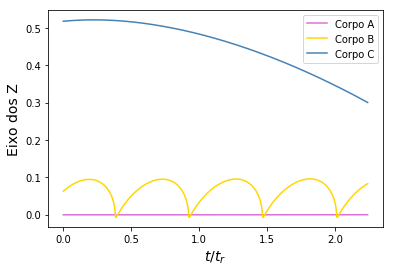

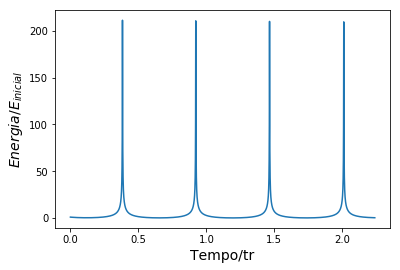

[1.48366144e+11 2.32238158e+13] [6.18084493e+12 2.75417828e+13]
5 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.00823600488391221 2.2391517639286644
1000 passos. T0,Tf =  0.06882369044693673 2.2391517639286644
5000 passos. T0,Tf =  0.18847721239356777 2.2391517639286644
10000 passos. T0,Tf =  0.3777420215419121 2.2391517639286644
25000 passos. T0,Tf =  0.39572832990838724 2.2391517639286644
50000 passos. T0,Tf =  0.9393845232374011 2.2391517639286644
75000 passos. T0,Tf =  1.4819765881024352 2.2391517639286644
100000 passos. T0,Tf =  1.817071936542124 2.2391517639286644
125000 passos. T0,Tf =  2.1062903236148016 2.2391517639286644


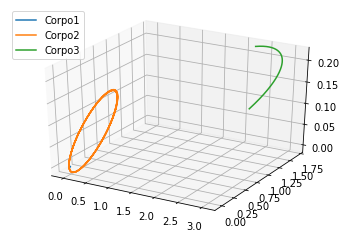

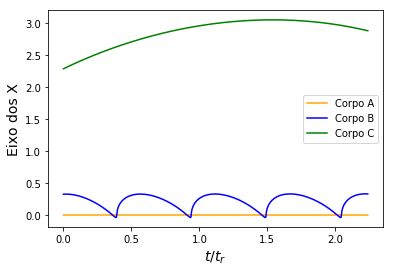

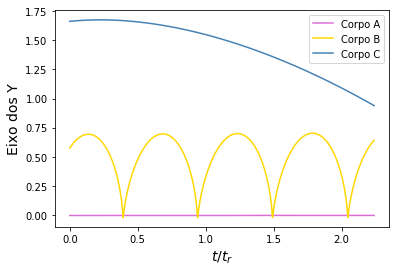

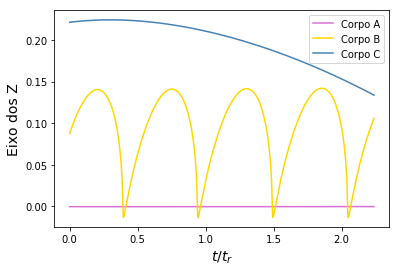

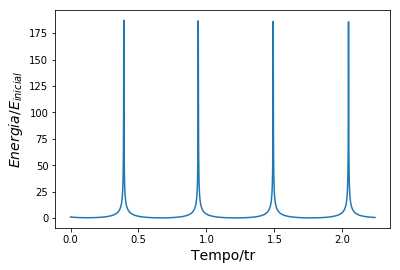

[1.60071245e+11 2.28870337e+13] [6.23221040e+12 2.71705077e+13]
6 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008661965818790033 2.2391517639286644
1000 passos. T0,Tf =  0.07441846660335823 2.2391517639286644
5000 passos. T0,Tf =  0.25695342559756945 2.2391517639286644
10000 passos. T0,Tf =  0.39400707872339963 2.2391517639286644
25000 passos. T0,Tf =  0.42591433060091205 2.2391517639286644
50000 passos. T0,Tf =  0.9680784039587027 2.2391517639286644
75000 passos. T0,Tf =  1.5259372020056212 2.2391517639286644
100000 passos. T0,Tf =  2.0883094113778253 2.2391517639286644


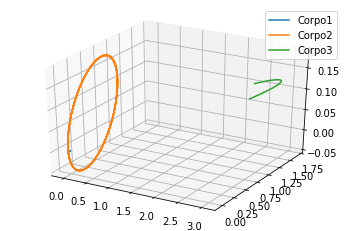

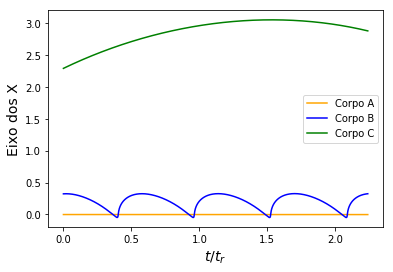

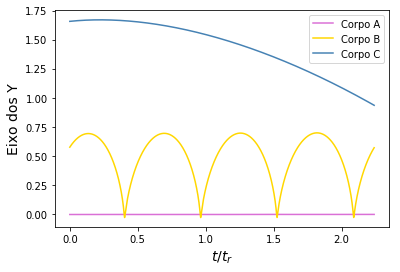

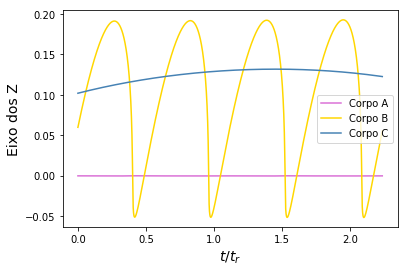

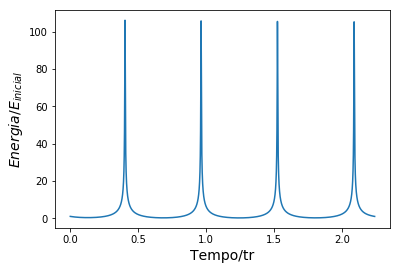

[2.46514595e+11 2.28626801e+13] [6.22207071e+12 2.71661940e+13]
7 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008423234182233966 2.2391517639286644
1000 passos. T0,Tf =  0.07085022282817405 2.2391517639286644
5000 passos. T0,Tf =  0.20118944957301124 2.2391517639286644
10000 passos. T0,Tf =  0.38570187022233604 2.2391517639286644
25000 passos. T0,Tf =  0.40396820243780696 2.2391517639286644
50000 passos. T0,Tf =  0.9530910819322987 2.2391517639286644
75000 passos. T0,Tf =  1.5072532417864937 2.2391517639286644
100000 passos. T0,Tf =  2.0240878345699342 2.2391517639286644


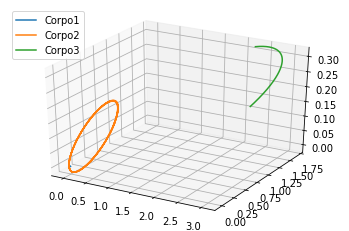

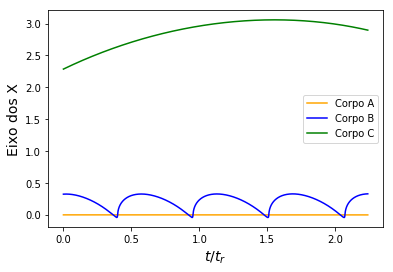

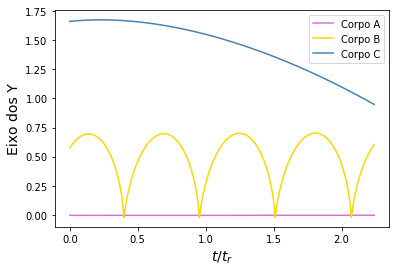

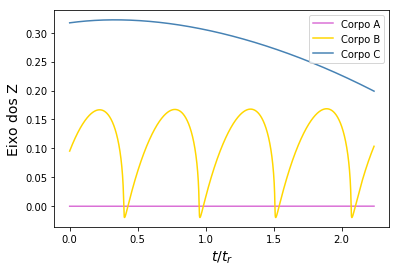

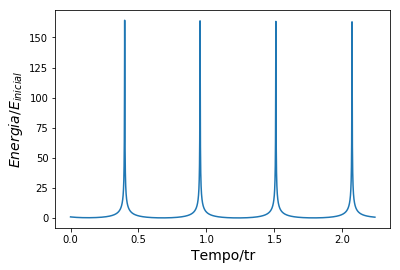

[1.75602707e+11 2.29667979e+13] [6.26428583e+12 2.72811212e+13]
8 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008000123354547714 2.2391517639286644
1000 passos. T0,Tf =  0.06653617164631564 2.2391517639286644
5000 passos. T0,Tf =  0.18441444645284363 2.2391517639286644
10000 passos. T0,Tf =  0.3687837805967916 2.2391517639286644
25000 passos. T0,Tf =  0.38610482902927246 2.2391517639286644
50000 passos. T0,Tf =  0.9201447604573308 2.2391517639286644
75000 passos. T0,Tf =  1.3986456512063499 2.2391517639286644
100000 passos. T0,Tf =  1.6541941227400214 2.2391517639286644
125000 passos. T0,Tf =  2.0134591984290124 2.2391517639286644


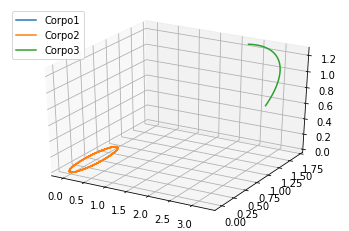

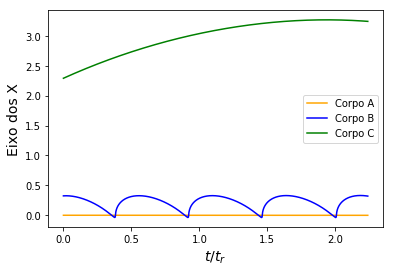

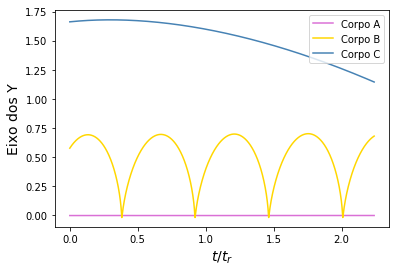

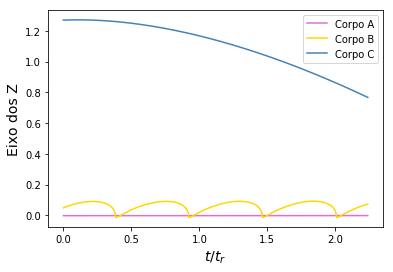

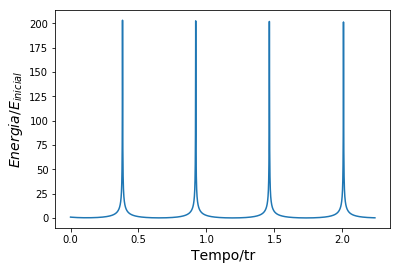

[1.56016446e+11 2.50653642e+13] [6.16787832e+12 2.97584489e+13]
9 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.007923991123327728 2.2391517639286644
1000 passos. T0,Tf =  0.06569322128941923 2.2391517639286644
5000 passos. T0,Tf =  0.18427748805035143 2.2391517639286644
10000 passos. T0,Tf =  0.3679875760686104 2.2391517639286644
25000 passos. T0,Tf =  0.38399867541479615 2.2391517639286644
50000 passos. T0,Tf =  0.917581420495581 2.2391517639286644
75000 passos. T0,Tf =  1.4179566371204304 2.2391517639286644
100000 passos. T0,Tf =  1.6565498049901244 2.2391517639286644
125000 passos. T0,Tf =  2.0112039684847196 2.2391517639286644


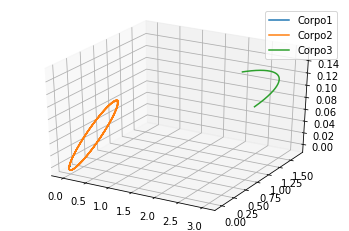

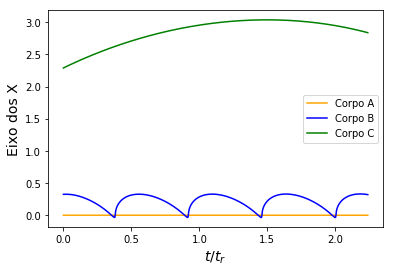

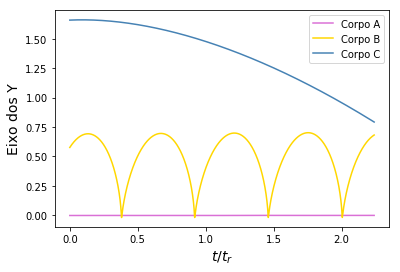

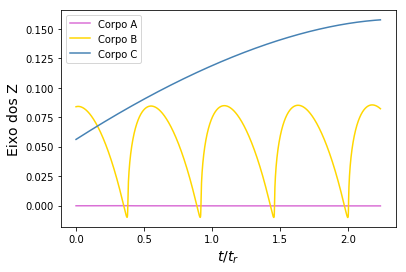

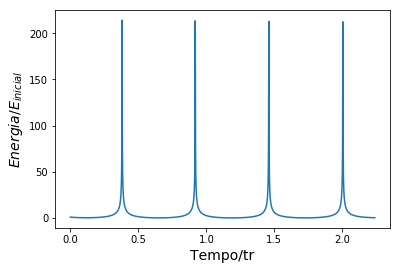

[1.48442529e+11 2.28483218e+13] [6.16920455e+12 2.68185972e+13]
10 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.007863321148235255 2.2391517639286644
1000 passos. T0,Tf =  0.0650552737587147 2.2391517639286644
5000 passos. T0,Tf =  0.1820862983305428 2.2391517639286644
10000 passos. T0,Tf =  0.3657070746249317 2.2391517639286644
25000 passos. T0,Tf =  0.3812529531248751 2.2391517639286644
50000 passos. T0,Tf =  0.9121147281307516 2.2391517639286644
75000 passos. T0,Tf =  1.4274317955523252 2.2391517639286644
100000 passos. T0,Tf =  1.668924295130419 2.2391517639286644
125000 passos. T0,Tf =  2.001022059078468 2.2391517639286644


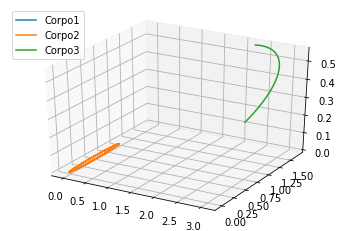

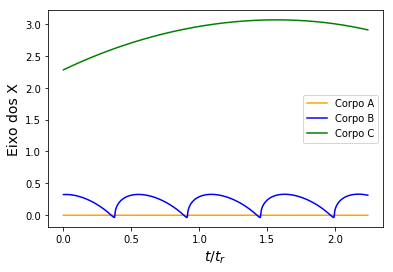

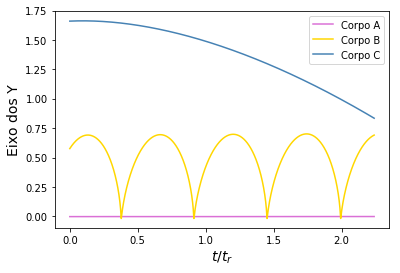

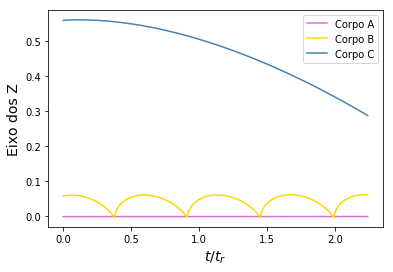

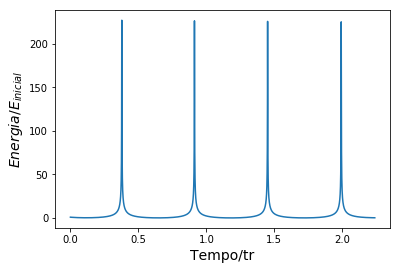

[1.41311218e+11 2.32507477e+13] [6.15275685e+12 2.72585464e+13]
11 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008283935676549066 2.2391517639286644
1000 passos. T0,Tf =  0.06854981544759856 2.2391517639286644
5000 passos. T0,Tf =  0.19929019397378386 2.2391517639286644
10000 passos. T0,Tf =  0.3860457560542495 2.2391517639286644
25000 passos. T0,Tf =  0.4008416646504679 2.2391517639286644
50000 passos. T0,Tf =  0.9561921585526165 2.2391517639286644
75000 passos. T0,Tf =  1.449083357414127 2.2391517639286644
100000 passos. T0,Tf =  1.6722018726274896 2.2391517639286644
125000 passos. T0,Tf =  2.0901327264918046 2.2391517639286644


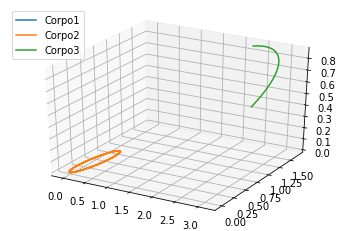

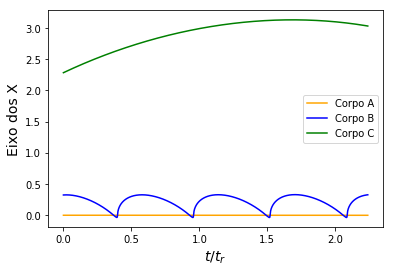

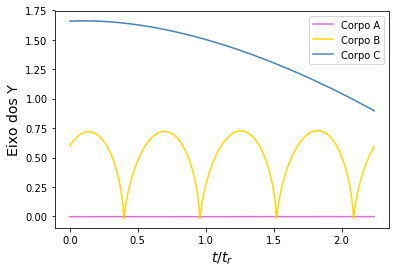

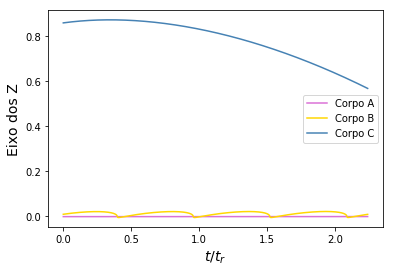

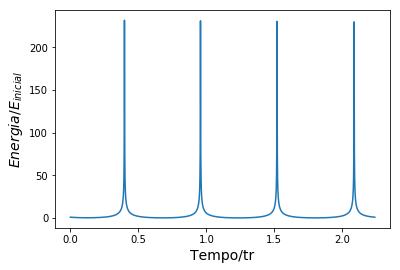

[1.38481781e+11 2.38305363e+13] [6.35101227e+12 2.80752966e+13]
12 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008314931355254386 2.2391517639286644
1000 passos. T0,Tf =  0.06880500312368493 2.2391517639286644
5000 passos. T0,Tf =  0.19591334016279932 2.2391517639286644
10000 passos. T0,Tf =  0.38689314067394165 2.2391517639286644
25000 passos. T0,Tf =  0.40213987266818035 2.2391517639286644
50000 passos. T0,Tf =  0.9593529722106817 2.2391517639286644
75000 passos. T0,Tf =  1.451314011480595 2.2391517639286644
100000 passos. T0,Tf =  1.669321028540554 2.2391517639286644
125000 passos. T0,Tf =  2.0969381230296964 2.2391517639286644


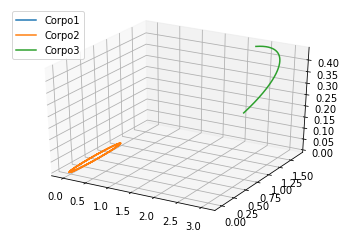

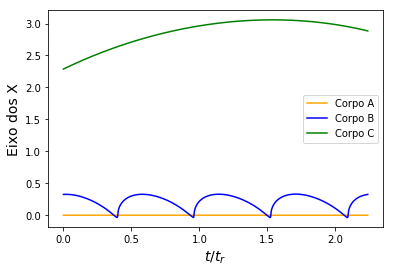

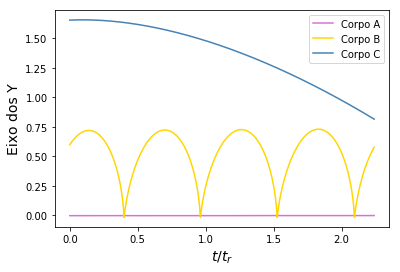

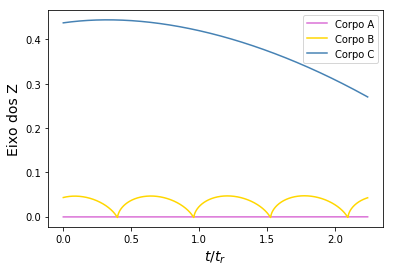

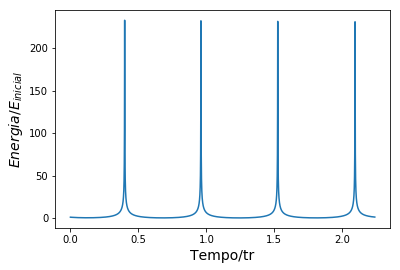

[1.37022105e+11 2.30742660e+13] [6.36577229e+12 2.70933075e+13]
13 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0083520363581111 2.2391517639286644
1000 passos. T0,Tf =  0.06914977497479487 2.2391517639286644
5000 passos. T0,Tf =  0.20720863714590732 2.2391517639286644
10000 passos. T0,Tf =  0.38980308145057263 2.2391517639286644
25000 passos. T0,Tf =  0.4041892420257628 2.2391517639286644
50000 passos. T0,Tf =  0.9640361354584104 2.2391517639286644
75000 passos. T0,Tf =  1.526341265874578 2.2391517639286644
100000 passos. T0,Tf =  1.8999647866594862 2.2391517639286644
125000 passos. T0,Tf =  2.15671795056615 2.2391517639286644


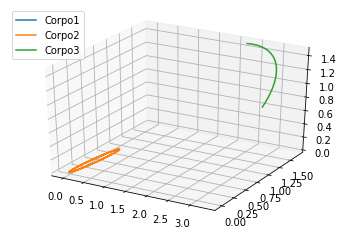

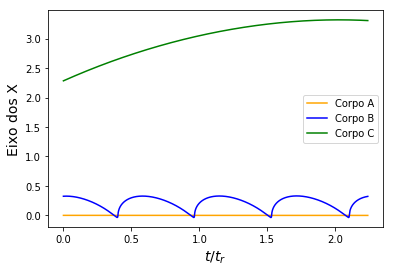

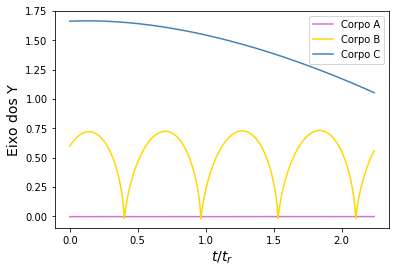

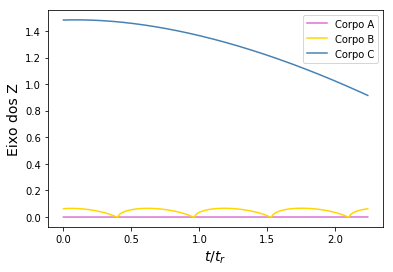

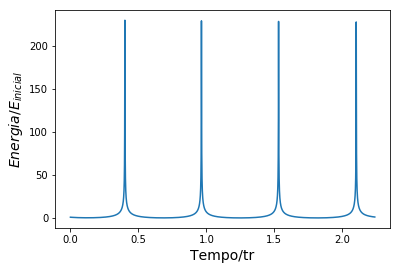

[1.41596580e+11 2.57725473e+13] [6.38087718e+12 3.01761769e+13]
14 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.00847194003616542 2.2391517639286644
1000 passos. T0,Tf =  0.07039368172213174 2.2391517639286644
5000 passos. T0,Tf =  0.2067771844790998 2.2391517639286644
10000 passos. T0,Tf =  0.393385229022315 2.2391517639286644
25000 passos. T0,Tf =  0.4086381554689491 2.2391517639286644
50000 passos. T0,Tf =  0.9714579308777702 2.2391517639286644
75000 passos. T0,Tf =  1.5158155484100422 2.2391517639286644
100000 passos. T0,Tf =  1.775250938646104 2.2391517639286644
125000 passos. T0,Tf =  2.1250024910875553 2.2391517639286644


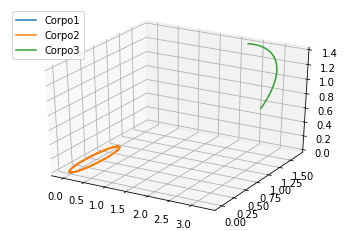

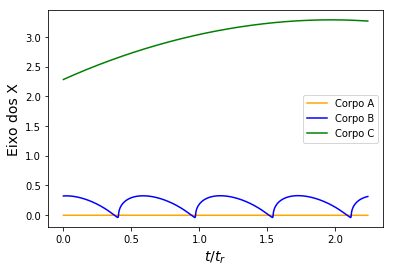

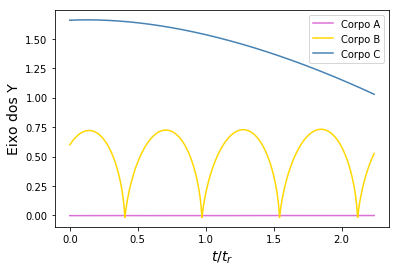

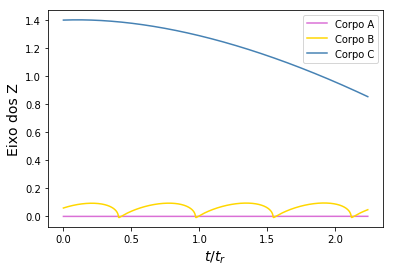

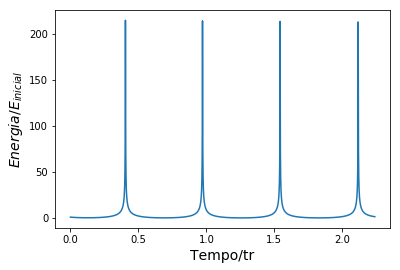

[1.47878868e+11 2.54591431e+13] [6.39987158e+12 2.98288744e+13]
15 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.00843301501539637 2.2391517639286644
1000 passos. T0,Tf =  0.07003250115939924 2.2391517639286644
5000 passos. T0,Tf =  0.20843875987922547 2.2391517639286644
10000 passos. T0,Tf =  0.3921290686401643 2.2391517639286644
25000 passos. T0,Tf =  0.40708352999539954 2.2391517639286644
50000 passos. T0,Tf =  0.9680994445176212 2.2391517639286644
75000 passos. T0,Tf =  1.5041679847700844 2.2391517639286644
100000 passos. T0,Tf =  1.7607069720322812 2.2391517639286644
125000 passos. T0,Tf =  2.11649172962908 2.2391517639286644


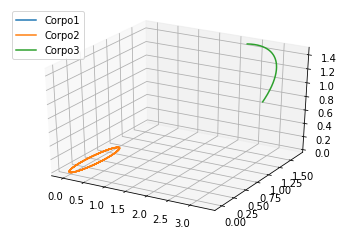

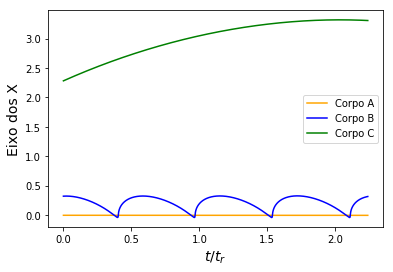

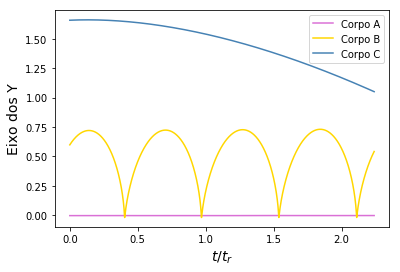

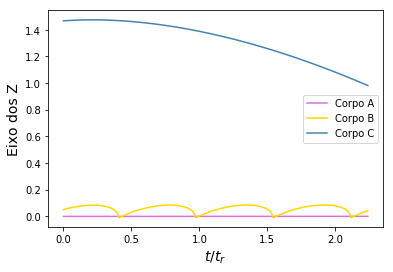

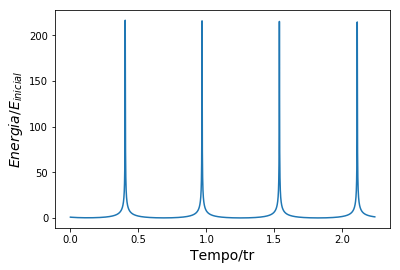

[1.47714614e+11 2.56875426e+13] [6.38716904e+12 3.02552602e+13]
16 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.008603148256950282 2.2391517639286644
1000 passos. T0,Tf =  0.0719523254642777 2.2391517639286644
5000 passos. T0,Tf =  0.20799346641939626 2.2391517639286644
10000 passos. T0,Tf =  0.3965614174926396 2.2391517639286644
25000 passos. T0,Tf =  0.4133453383219765 2.2391517639286644
50000 passos. T0,Tf =  0.9780679194317711 2.2391517639286644
75000 passos. T0,Tf =  1.5349647807252498 2.2391517639286644
100000 passos. T0,Tf =  1.8525425447550172 2.2391517639286644
125000 passos. T0,Tf =  2.1643538112168303 2.2391517639286644


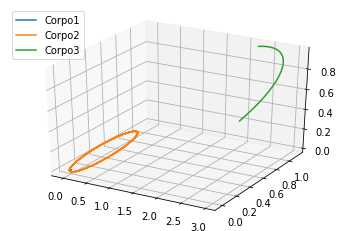

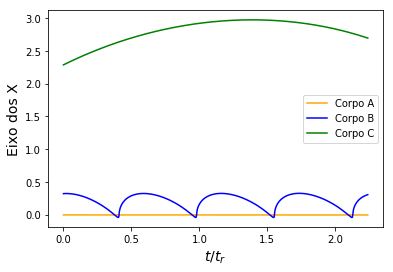

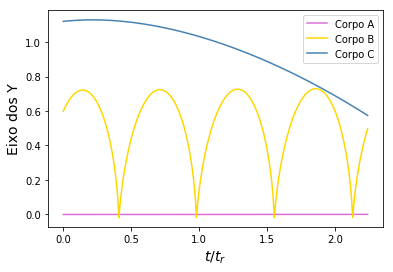

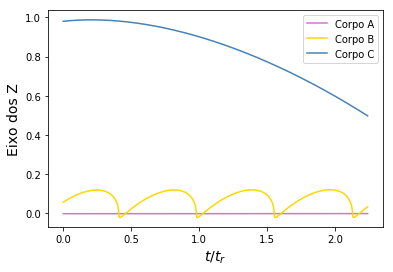

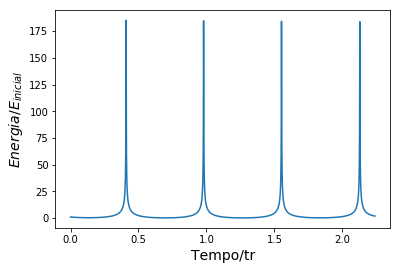

[1.59716446e+11 2.20335928e+13] [6.40020763e+12 2.61264374e+13]
17 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0021104317383224946 2.2391517639286644
1000 passos. T0,Tf =  0.020379663942943743 2.2391517639286644
5000 passos. T0,Tf =  0.08265503645125577 2.2391517639286644
10000 passos. T0,Tf =  0.09349086387378273 2.2391517639286644
25000 passos. T0,Tf =  0.19841956156959992 2.2391517639286644
50000 passos. T0,Tf =  0.39708870811903646 2.2391517639286644
75000 passos. T0,Tf =  0.5991771559096509 2.2391517639286644
100000 passos. T0,Tf =  0.7870582347953152 2.2391517639286644
125000 passos. T0,Tf =  0.9693353868843699 2.2391517639286644
150000 passos. T0,Tf =  1.149763054446004 2.2391517639286644
200000 passos. T0,Tf =  1.5100573202326193 2.2391517639286644


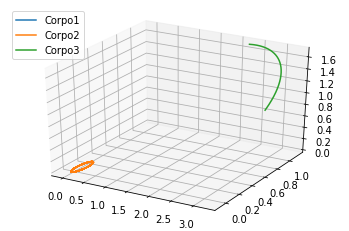

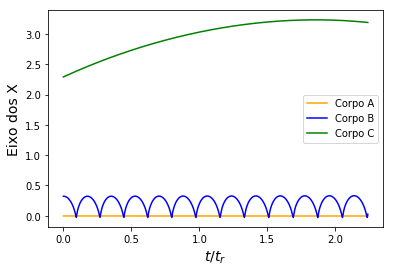

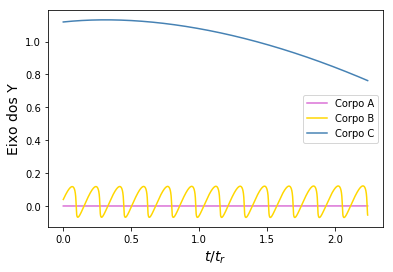

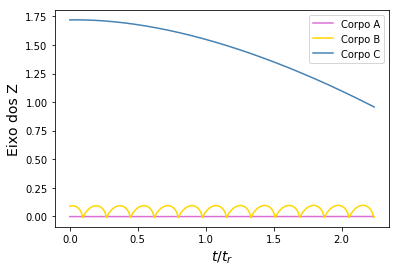

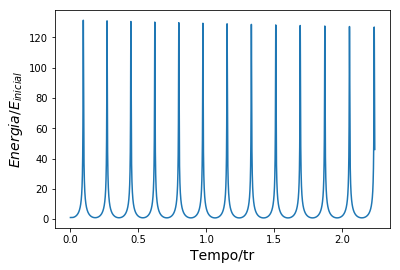

[2.2268526e+11 2.4854434e+13] [2.81193547e+12 2.91756910e+13]
18 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.009058635371979764 2.2391517639286644
1000 passos. T0,Tf =  0.0910907482223888 2.2391517639286644
5000 passos. T0,Tf =  0.2836228194308621 2.2391517639286644
10000 passos. T0,Tf =  0.3193548687323284 2.2391517639286644
25000 passos. T0,Tf =  0.883716687052975 2.2391517639286644
50000 passos. T0,Tf =  1.5131751281867645 2.2391517639286644
75000 passos. T0,Tf =  2.1496613778066576 2.2391517639286644


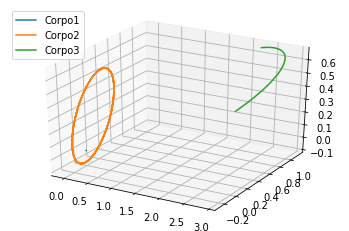

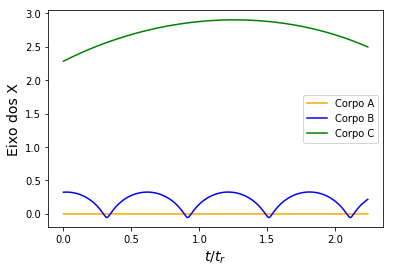

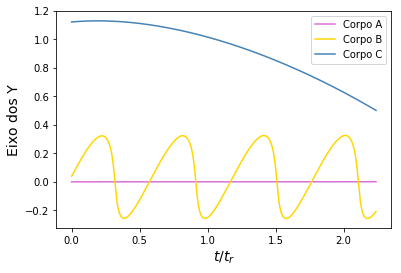

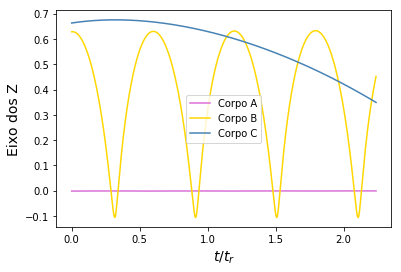

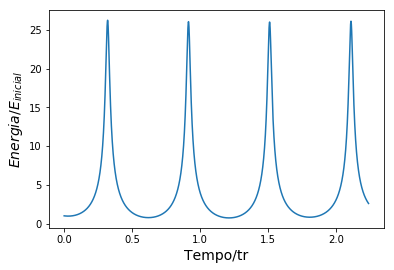

[9.57581043e+11 2.07615023e+13] [5.76978928e+12 2.51888738e+13]
19 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0021511874810349265 2.2391517639286644
1000 passos. T0,Tf =  0.020783603654752413 2.2391517639286644
5000 passos. T0,Tf =  0.07940561156820597 2.2391517639286644
10000 passos. T0,Tf =  0.08923426434031403 2.2391517639286644
25000 passos. T0,Tf =  0.20974781886275662 2.2391517639286644
50000 passos. T0,Tf =  0.41261134865245686 2.2391517639286644
75000 passos. T0,Tf =  0.5916767910764869 2.2391517639286644
100000 passos. T0,Tf =  0.7650448081554055 2.2391517639286644
125000 passos. T0,Tf =  0.9373657000119785 2.2391517639286644
150000 passos. T0,Tf =  1.1100183158293522 2.2391517639286644
200000 passos. T0,Tf =  1.460958613053765 2.2391517639286644


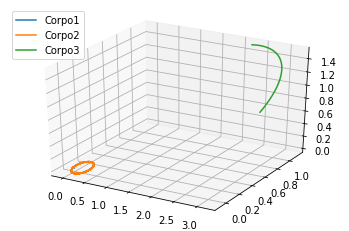

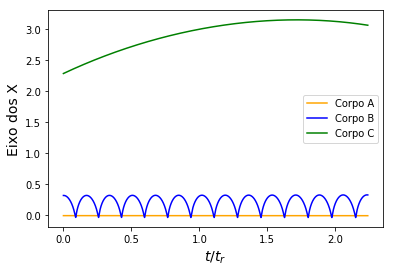

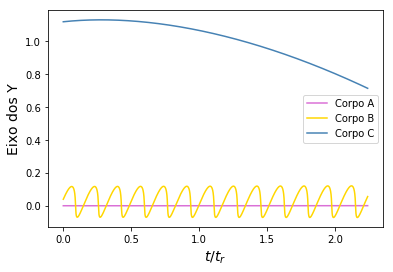

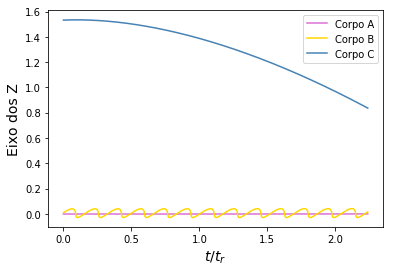

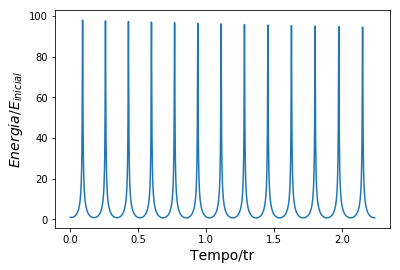

[2.50847076e+11 2.40014906e+13] [2.70911699e+12 2.82928423e+13]
20 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.006889349279797399 2.2391517639286644
1000 passos. T0,Tf =  0.06780754193769592 2.2391517639286644
5000 passos. T0,Tf =  0.23161176840597114 2.2391517639286644
10000 passos. T0,Tf =  0.2600376994570949 2.2391517639286644
25000 passos. T0,Tf =  0.6862570129486473 2.2391517639286644
50000 passos. T0,Tf =  1.1739351918478447 2.2391517639286644
75000 passos. T0,Tf =  1.6491918003471286 2.2391517639286644
100000 passos. T0,Tf =  2.179617056607371 2.2391517639286644


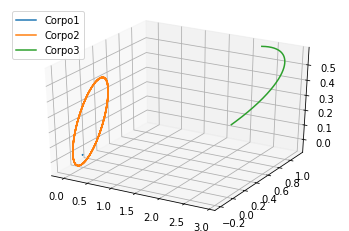

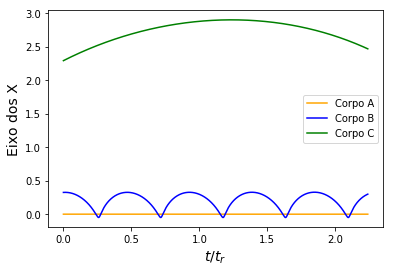

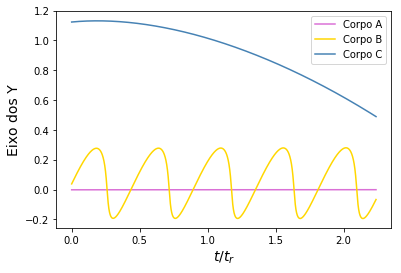

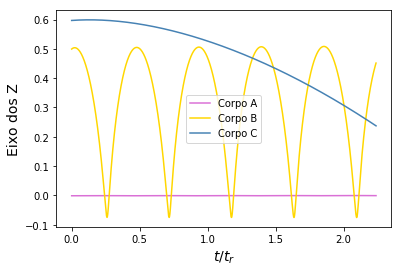

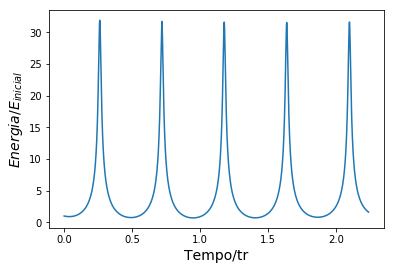

[7.27499245e+11 2.04005489e+13] [4.92643420e+12 2.50266333e+13]
21 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0067141621406264645 2.2391517639286644
1000 passos. T0,Tf =  0.06559239484252652 2.2391517639286644
5000 passos. T0,Tf =  0.229118865607728 2.2391517639286644
10000 passos. T0,Tf =  0.25744985340269816 2.2391517639286644
25000 passos. T0,Tf =  0.6690519460740282 2.2391517639286644
50000 passos. T0,Tf =  1.1463047002688358 2.2391517639286644
75000 passos. T0,Tf =  1.607179877510721 2.2391517639286644
100000 passos. T0,Tf =  2.1004388263350124 2.2391517639286644


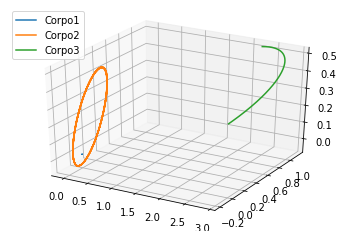

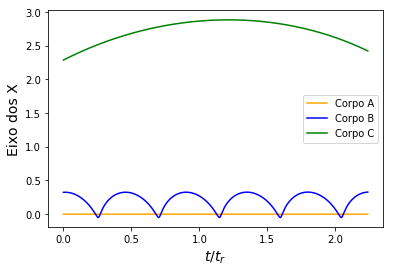

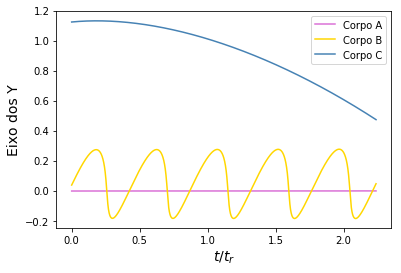

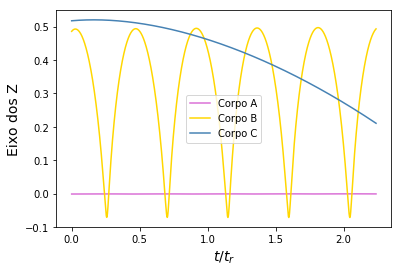

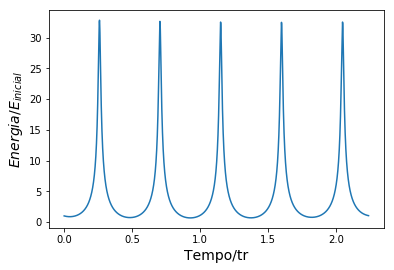

[6.96695771e+11 2.00164455e+13] [4.85754614e+12 2.48475621e+13]
22 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0022585291354014054 2.2391517639286644
1000 passos. T0,Tf =  0.02173674103070857 2.2391517639286644
5000 passos. T0,Tf =  0.08564609175060449 2.2391517639286644
10000 passos. T0,Tf =  0.0966291915074264 2.2391517639286644
25000 passos. T0,Tf =  0.21456879897415546 2.2391517639286644
50000 passos. T0,Tf =  0.43248020468611964 2.2391517639286644
75000 passos. T0,Tf =  0.6301496503437441 2.2391517639286644
100000 passos. T0,Tf =  0.8178044505791096 2.2391517639286644
125000 passos. T0,Tf =  1.0028683175263222 2.2391517639286644
150000 passos. T0,Tf =  1.1875035842427049 2.2391517639286644
200000 passos. T0,Tf =  1.5582262012420596 2.2391517639286644


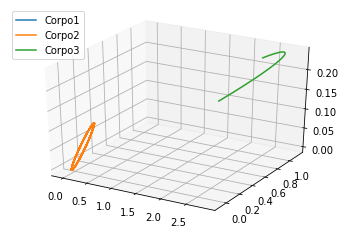

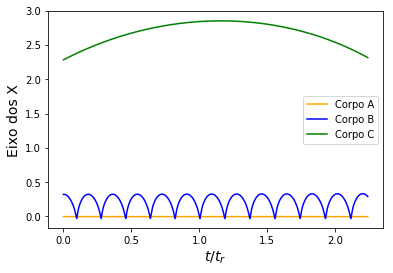

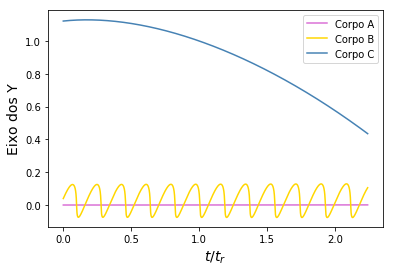

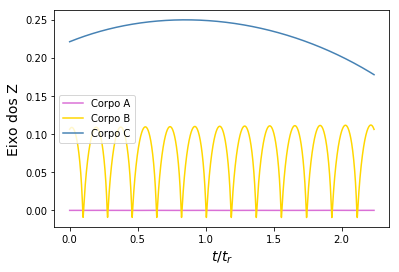

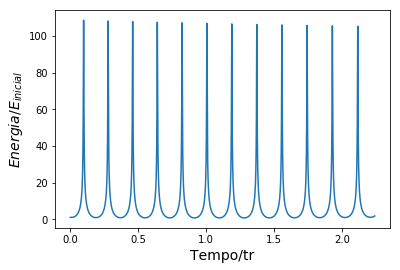

[2.44461607e+11 1.90945116e+13] [2.85173347e+12 2.44275630e+13]
23 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.009062085833999672 2.2391517639286644
1000 passos. T0,Tf =  0.08870650682031814 2.2391517639286644
5000 passos. T0,Tf =  0.29979096012592704 2.2391517639286644
10000 passos. T0,Tf =  0.3397197644193623 2.2391517639286644
25000 passos. T0,Tf =  0.8878942962349496 2.2391517639286644
50000 passos. T0,Tf =  1.5056829257154358 2.2391517639286644
75000 passos. T0,Tf =  2.136070208017549 2.2391517639286644


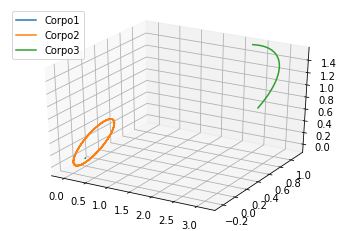

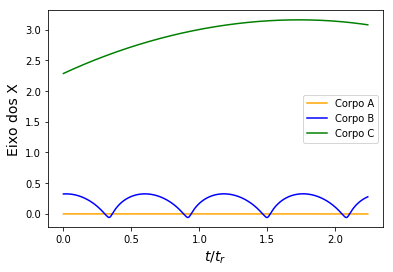

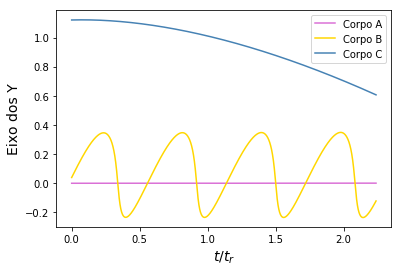

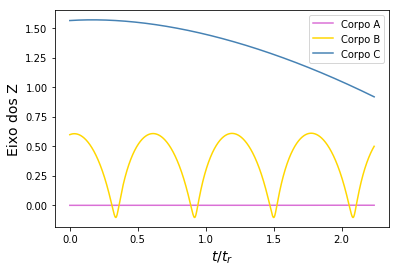

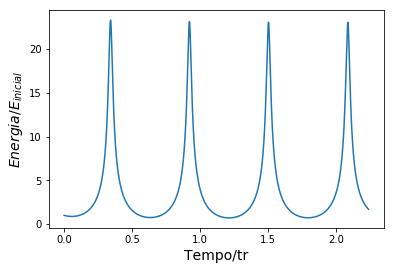

[9.66232596e+11 2.41324250e+13] [5.64857419e+12 2.83766302e+13]
24 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0033429979964794557 2.2391517639286644
1000 passos. T0,Tf =  0.031595514147553835 2.2391517639286644
5000 passos. T0,Tf =  0.12180754306152469 2.2391517639286644
10000 passos. T0,Tf =  0.13780373445263722 2.2391517639286644
25000 passos. T0,Tf =  0.3206497101956857 2.2391517639286644
50000 passos. T0,Tf =  0.6140880763120616 2.2391517639286644
75000 passos. T0,Tf =  0.8706388208560544 2.2391517639286644
100000 passos. T0,Tf =  1.1212499792261101 2.2391517639286644
125000 passos. T0,Tf =  1.3714860283282033 2.2391517639286644
150000 passos. T0,Tf =  1.623658607046143 2.2391517639286644
200000 passos. T0,Tf =  2.174422774979105 2.2391517639286644


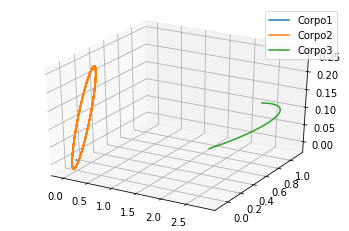

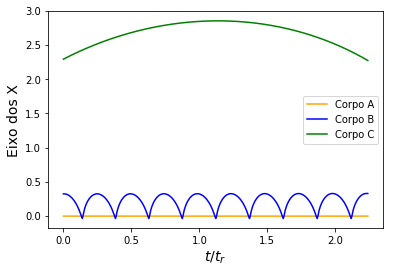

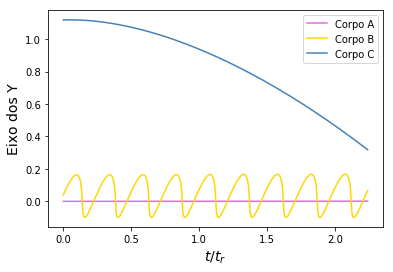

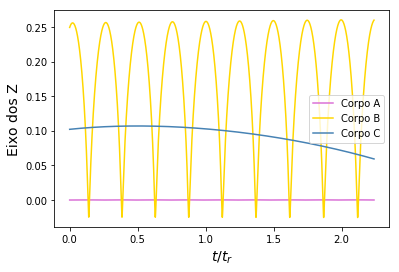

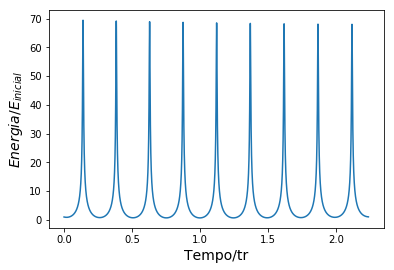

[3.45587506e+11 1.85384789e+13] [3.41730865e+12 2.42042204e+13]
25 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.003414299110541012 2.2391517639286644
1000 passos. T0,Tf =  0.032961563535784145 2.2391517639286644
5000 passos. T0,Tf =  0.12348190342299951 2.2391517639286644
10000 passos. T0,Tf =  0.13857196497429516 2.2391517639286644
25000 passos. T0,Tf =  0.3449422311123051 2.2391517639286644
50000 passos. T0,Tf =  0.6358150137759825 2.2391517639286644
75000 passos. T0,Tf =  0.898004609076277 2.2391517639286644
100000 passos. T0,Tf =  1.1566961003774499 2.2391517639286644
125000 passos. T0,Tf =  1.417121218662395 2.2391517639286644
150000 passos. T0,Tf =  1.6876467943437183 2.2391517639286644


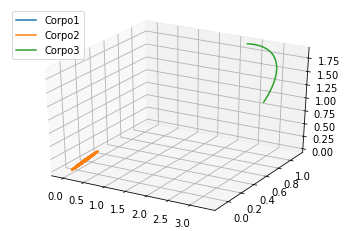

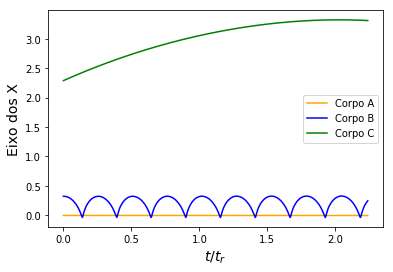

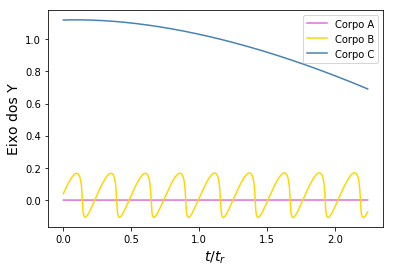

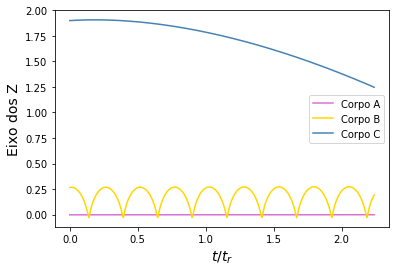

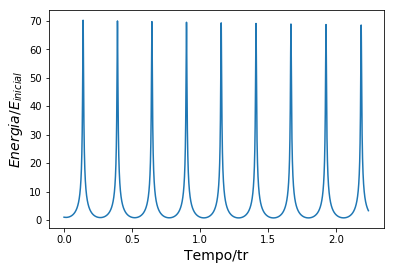

[3.66704232e+11 2.56775163e+13] [3.47251723e+12 3.02405201e+13]
26 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0020537525888305666 2.2391517639286644
1000 passos. T0,Tf =  0.01954503032213795 2.2391517639286644
5000 passos. T0,Tf =  0.07840200849754908 2.2391517639286644
10000 passos. T0,Tf =  0.0886477565480382 2.2391517639286644
25000 passos. T0,Tf =  0.19358502594971194 2.2391517639286644
50000 passos. T0,Tf =  0.3898576300314788 2.2391517639286644
75000 passos. T0,Tf =  0.5806649746962438 2.2391517639286644
100000 passos. T0,Tf =  0.7583825597699712 2.2391517639286644
125000 passos. T0,Tf =  0.9322122617298758 2.2391517639286644
150000 passos. T0,Tf =  1.1049427241834258 2.2391517639286644
200000 passos. T0,Tf =  1.4506582413758313 2.2391517639286644


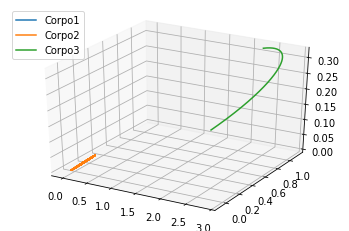

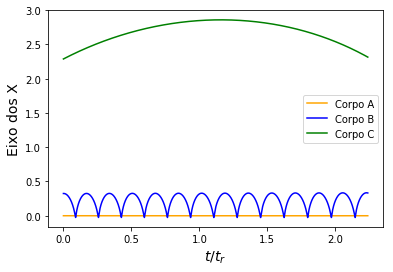

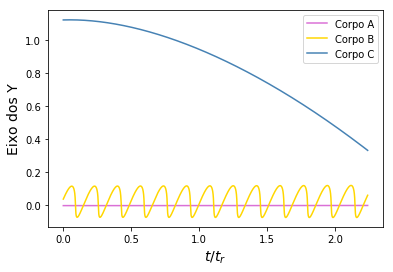

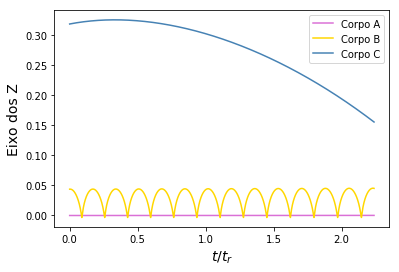

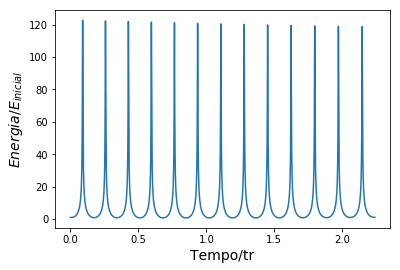

[2.24567164e+11 1.89345402e+13] [2.74016948e+12 2.43718209e+13]
27 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0036240107970783022 2.2391517639286644
1000 passos. T0,Tf =  0.03571903066495524 2.2391517639286644
5000 passos. T0,Tf =  0.12767456373190095 2.2391517639286644
10000 passos. T0,Tf =  0.1420350998594817 2.2391517639286644
25000 passos. T0,Tf =  0.37500967988441153 2.2391517639286644
50000 passos. T0,Tf =  0.6709346934138509 2.2391517639286644
75000 passos. T0,Tf =  0.9461232583483032 2.2391517639286644
100000 passos. T0,Tf =  1.2198980193378446 2.2391517639286644
125000 passos. T0,Tf =  1.498928425566064 2.2391517639286644
150000 passos. T0,Tf =  1.8087523707930944 2.2391517639286644


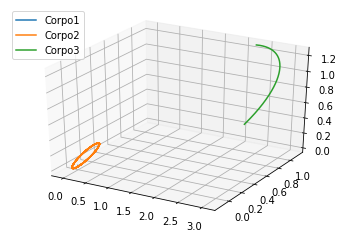

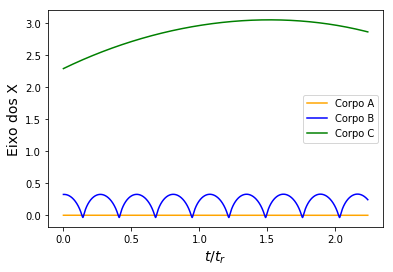

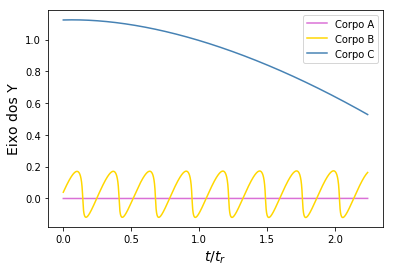

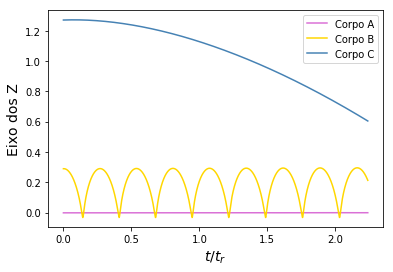

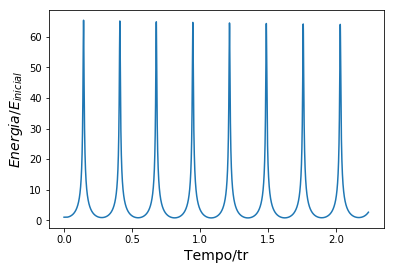

[3.94673046e+11 2.30033881e+13] [3.59099461e+12 2.69180760e+13]
28 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0020942770756750655 2.2391517639286644
1000 passos. T0,Tf =  0.020033251928927905 2.2391517639286644
5000 passos. T0,Tf =  0.07985729000419445 2.2391517639286644
10000 passos. T0,Tf =  0.0902012186029679 2.2391517639286644
25000 passos. T0,Tf =  0.19936005237291038 2.2391517639286644
50000 passos. T0,Tf =  0.40189188416670096 2.2391517639286644
75000 passos. T0,Tf =  0.5927491218920645 2.2391517639286644
100000 passos. T0,Tf =  0.772038950304178 2.2391517639286644
125000 passos. T0,Tf =  0.948077422370626 2.2391517639286644
150000 passos. T0,Tf =  1.123370536451038 2.2391517639286644
200000 passos. T0,Tf =  1.4750123107287254 2.2391517639286644


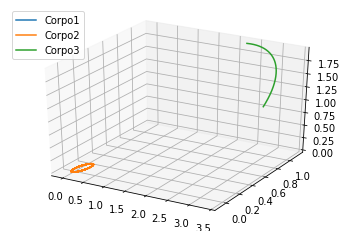

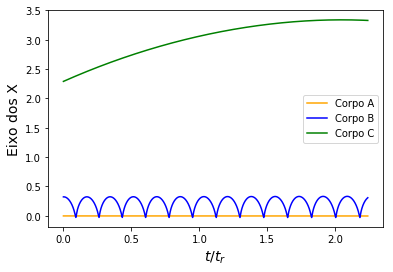

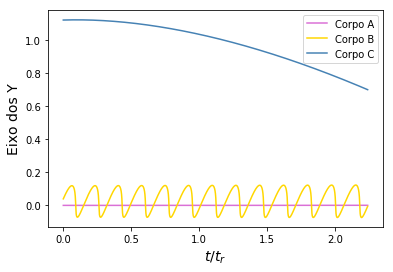

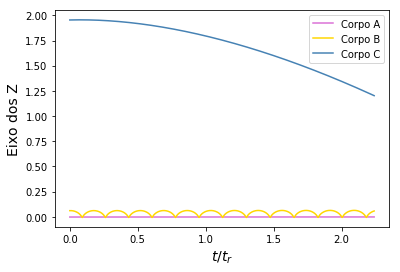

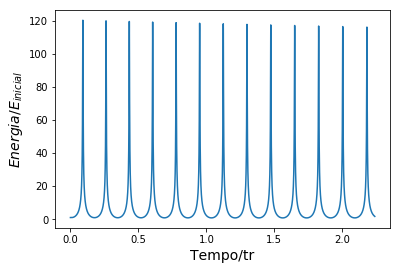

[2.31542242e+11 2.59599673e+13] [2.75249297e+12 3.02953747e+13]
29 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.0054697930266746474 2.2391517639286644
1000 passos. T0,Tf =  0.054513615716609 2.2391517639286644
5000 passos. T0,Tf =  0.18010547744699748 2.2391517639286644
10000 passos. T0,Tf =  0.20105824971237551 2.2391517639286644
25000 passos. T0,Tf =  0.5527545363663381 2.2391517639286644
50000 passos. T0,Tf =  0.9550766828301109 2.2391517639286644
75000 passos. T0,Tf =  1.3460107936810564 2.2391517639286644
100000 passos. T0,Tf =  1.771217655740998 2.2391517639286644


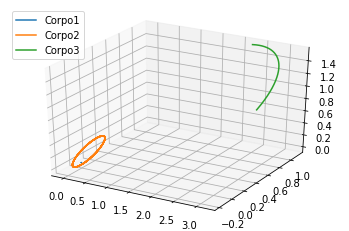

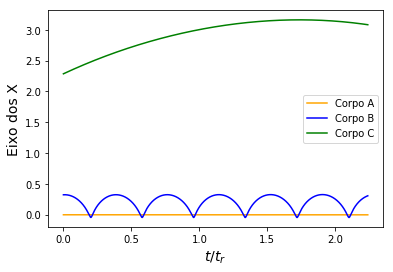

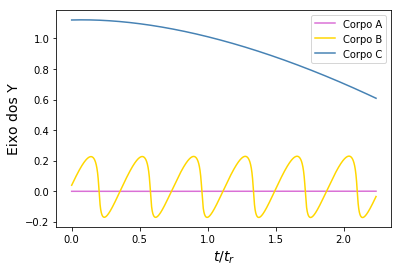

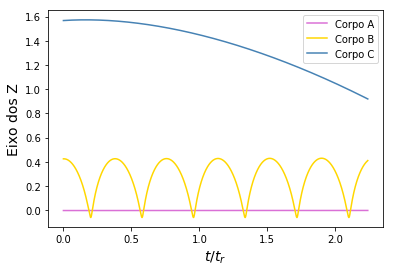

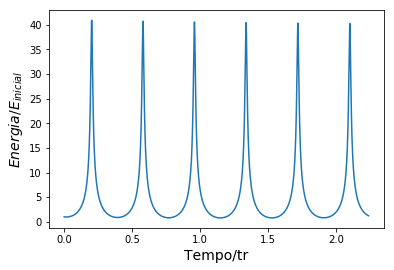

[6.03366287e+11 2.41632954e+13] [4.38210065e+12 2.84128857e+13]
30 de 30

 s  =   0.0  %

 s  =   33.33333333333333  %

 s  =   66.66666666666666  %
100 passos. T0,Tf =  0.003101251017009156 2.2391517639286644
1000 passos. T0,Tf =  0.030924474458404568 2.2391517639286644
5000 passos. T0,Tf =  0.11240480865953163 2.2391517639286644
10000 passos. T0,Tf =  0.12473214526055268 2.2391517639286644
25000 passos. T0,Tf =  0.31908825520490364 2.2391517639286644
50000 passos. T0,Tf =  0.5864103157050312 2.2391517639286644
75000 passos. T0,Tf =  0.829911636633387 2.2391517639286644
100000 passos. T0,Tf =  1.0700058888687745 2.2391517639286644
125000 passos. T0,Tf =  1.310616850746918 2.2391517639286644
150000 passos. T0,Tf =  1.5544792069518847 2.2391517639286644


In [ ]:
N = 30
# vb = 27.82 + 1.56*rd.random()  #duas vezes a incerteza, valor é 28.50 +- 0.78
# vc = 14.2 + 2.4*rd.random()  #15.4 +-1.2
ab = 0.54*ua
vb = np.sqrt(G*(mb+m_HD)/(ab))
ac = 2.95 * ua
vc = np.sqrt(G*(mc+m_HD)/(ac))
# vb = 27.82
# vc = 15.4
unit1,unit2,unit3 = random_normalizado(N,vb,0.78)
unit4,unit5,unit6 = random_normalizado(N,vc,1.2)
#Agora para as posições iniciais, de modo a que sejam aleatórias e não sejam
# "direitinhas" no afélio
pos1,pos2,pos3 = random_normalizado(N,ab,0.00020*ua)
pos4,pos5,pos6 = random_normalizado(N,ac,0.0065*ua) 
#print(len(unit1),unit4)
exc_list = np.zeros(N)
exc_list2 = np.zeros(N)
for i in range(N):
    print(i+1 , 'de', N)
    A = trajetoria3D_exc(3,np.array([m_HD,mb,mc]),0,
                    np.array([0,0,0,pos1[i],pos2[i],pos3[i],pos4[i],pos5[i],pos6[i]]),
            np.array([0,0,0,unit1[i],unit2[i],unit3[i],unit4[i],unit5[i],unit6[i]]),
                                   ab,T_b,T_c)
    exc_list[i] = A[0]
    exc_list2[i] = A[1]
print('\n EXC planeta b')
plt.hist(exc_list)
plt.show()
print('\n EXC planeta c')
plt.hist(exc_list2)
plt.show()
mean = np.sum(exc_list)/N
print('Excentricidade média foi: ' , mean)